<a href="https://colab.research.google.com/github/mbc2009/Lmp_ML/blob/main/Trials/Trial_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Enviornment Initialization

In [1]:
%%capture
%%bash

# remove unnecessary
rm -rf *

# update pip
python -m pip install --upgrade pip

# install package
pip install opencv-python pillow
pip install segmentation_models_pytorch
pip install -q kaggle
pip install dropbox
pip install scikit-image
pip install pandas openpyxl

In [2]:
# basic import
import  os, sys, time, math, random, math, psutil, h5py, re, pickle
from    datetime                import datetime
from    concurrent.futures      import ThreadPoolExecutor
from    typing                  import  List, Tuple
from    dropbox                 import  Dropbox
from    tqdm                    import  tqdm
from    mpl_toolkits.mplot3d    import  Axes3D
from    matplotlib              import  pyplot      as plt
import  numpy                                       as np
import  pandas                                      as pd
import  zipfile
import  warnings
import  shutil
import  joblib

from    sklearn.preprocessing   import MinMaxScaler
from    sklearn.metrics         import r2_score, mean_absolute_error,mean_squared_error,explained_variance_score,mean_squared_log_error
from    skimage                 import  io
from    sklearn.model_selection import KFold

import  scipy
from    scipy                   import  interpolate,stats
from    scipy.interpolate       import  RegularGridInterpolator
from    scipy.ndimage           import  generic_filter, rotate

import  torch
from    torch                   import  nn
from    torch.nn                import  functional  as F
import  torch.optim                                 as optim
import  torchvision.transforms.functional           as TF
from    torch.utils.data        import  Dataset, DataLoader, TensorDataset, random_split, Subset
from    torchvision             import  transforms, models
from    torchvision.transforms  import  *
from    PIL                     import  Image
import  kagglehub

In [3]:
# check hardware
print(f"CPU core #:\t{os.cpu_count()}")
print(f"CPU threads #:\t{psutil.cpu_count(logical=True)}")
print(f"Total memory:\t\t{psutil.virtual_memory().total / (1024**3):.2f} GB")
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"available GPU #:\t{gpu_count}")
    for i in range(gpu_count):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i+1}:\t\t{gpu_name}")
else:
    print("No available GPU")

CPU core #:	12
CPU threads #:	12
Total memory:		83.48 GB
available GPU #:	1
GPU 1:		NVIDIA A100-SXM4-40GB


#1.Model Designing

In [4]:
class ViT3D(nn.Module):
    def __init__(self, input_dim=32 * 32 * 32, d_model=128, nhead=4, num_layers=2):
        super(ViT3D, self).__init__()
        self.fc1 = nn.Linear(input_dim, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc2 = nn.Linear(d_model + 1, 64)  # È¢ùÂ§ñÂä†ÂÖ• temp_i
        self.output_dim = len(conf.DB_items) - 1
        self.fc3 = nn.Linear(64, self.output_dim)

    def forward(self, x, tensor_i):
        x = x.view(x.size(0), -1)  # Â±ïÂπ≥
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(0)  # Transformer ËæìÂÖ•ÈúÄË¶Å (seq_len, batch, feature_dim)
        x = self.transformer(x)
        x = x.squeeze(0)  # ÊÅ¢Â§ç batch Áª¥Â∫¶
        temp_i = tensor_i.unsqueeze(1)
        x = torch.cat((x, temp_i), dim=1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Swin3D(nn.Module):
    def __init__(self, input_dim=32 * 32 * 32, d_model=128, nhead=4, num_layers=2):
        super(Swin3D, self).__init__()
        self.fc1 = nn.Linear(input_dim, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc2 = nn.Linear(d_model + 1, 64)  # È¢ùÂ§ñÂä†ÂÖ• temp_i
        self.output_dim = len(conf.DB_items) - 1
        self.fc3 = nn.Linear(64, self.output_dim)

    def forward(self, x, tensor_i):
        x = x.view(x.size(0), -1)  # Â±ïÂπ≥
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(0)  # Transformer ËæìÂÖ•ÈúÄË¶Å (seq_len, batch, feature_dim)
        x = self.transformer(x)
        x = x.squeeze(0)  # ÊÅ¢Â§ç batch Áª¥Â∫¶
        temp_i = tensor_i.unsqueeze(1)
        x = torch.cat((x, temp_i), dim=1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
class Pure3DCNN(nn.Module):
    def __init__(self):
        super(Pure3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool  = nn.MaxPool3d(2, 2)        # 2x2x2 Ê±†ÂåñÔºåÂ∞∫ÂØ∏ÂáèÂçä

        # Áî±‰∫éÂéªÊéâ TransformerÔºåfc1 ‰πãÂêéÁõ¥Êé•ËøõÂÖ• fc2
        self.fc1 = nn.Linear(32 * 32 * 32 * 32, 128)  # CNN ÊèêÂèñÁöÑÁâπÂæÅ
        self.fc2 = nn.Linear(128 + 1, 64)  # È¢ùÂ§ñÂä†ÂÖ• temp_iÔºà1 Áª¥Ôºâ
        self.output_dim = len(conf.DB_items) - 1  # ËÆ°ÁÆóËæìÂá∫Áª¥Â∫¶
        self.fc3 = nn.Linear(64, self.output_dim)  # ÊúÄÁªàËæìÂá∫Â±Ç

    def forward(self, x, tensor_i):
        x = self.pool(F.relu(self.conv1(x.float())))  # 128¬≥ -> 64¬≥
        x = self.pool(F.relu(self.conv2(x)))  # 64¬≥ -> 32¬≥
        x = x.view(-1, 32 * 32 * 32 * 32)  # Â±ïÂπ≥

        x = F.relu(self.fc1(x))  # fc1 out: CNN ÁâπÂæÅÊèêÂèñ

        temp_i  = tensor_i.unsqueeze(1)  # Âè™Âèñ temp_iÔºåÂΩ¢Áä∂Âèò‰∏∫ (batch_size, 1)
        x       = torch.cat((x, temp_i), dim=1)  # ÊãºÊé• temp_i

        x = F.relu(self.fc2(x))  # fc2 out: relu
        x = self.fc3(x)  # fc3 out: ËæìÂá∫ÊúÄÁªàÁªìÊûú
        return x

In [6]:
class Improved3DCNN(nn.Module):
    def __init__(self):
        super(Improved3DCNN, self).__init__()
        self.conv1  = nn.Conv3d(1,  16, kernel_size=3, stride=1, padding=1)
        self.conv2  = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool   = nn.MaxPool3d(2, 2)

        # Â≠êÂå∫ÂüüÈôçÁª¥Â±Ç
        self.subregion_fc = nn.Conv3d(32, 32, kernel_size=4, stride=4)  # 4√ó4√ó4 Âç∑ÁßØÔºåÂ∞ÜÊØè‰∏™Â≠êÂå∫ÂüüÈôçÁª¥

        # Transformer ÂèÇÊï∞Ë∞ÉÊï¥
        self.transformer = TransformerEncoderLayer(d_model=32, nhead=4, dim_feedforward=128, dropout=0.1)  # d_model Êîπ‰∏∫ 32

        # Transformer ËæìÂá∫ÈôçÁª¥
        self.fc_transformer = nn.Linear(512 * 32, 128)  # 512 ‰∏™Â≠êÂå∫ÂüüÔºåÊØè‰∏™ 32 Áª¥ÔºåÈôçÁª¥Âà∞ 128

        self.fc2 = nn.Linear(128 + 1, 64)
        self.output_dim = len(conf.DB_items) - 1
        self.fc3 = nn.Linear(64, self.output_dim)

    def forward(self, x, tensor_i):
        x = self.pool(F.relu(self.conv1(x.float())))  # 128¬≥ -> 64¬≥
        x = self.pool(F.relu(self.conv2(x)))  # 64¬≥ -> 32¬≥

        # ÂàíÂàÜÂ≠êÂå∫ÂüüÔºö32¬≥ ÂàíÂàÜ‰∏∫ 8√ó8√ó8 ‰∏™ 4√ó4√ó4 Â≠êÂå∫Âüü
        x = self.subregion_fc(x)  # (batch_size, 32, 8, 8, 8)
        x = x.view(-1, 32, 8 * 8 * 8)  # (batch_size, 32, 512)
        x = x.permute(2, 0, 1)  # (512, batch_size, 32) for Transformer

        # Transformer Â§ÑÁêÜ
        x = self.transformer(x)  # (512, batch_size, 32)
        x = x.permute(1, 0, 2)  # (batch_size, 512, 32)
        x = x.reshape(-1, 512 * 32)  # (batch_size, 512 * 32)
        x = F.relu(self.fc_transformer(x))  # (batch_size, 128)

        # ÊãºÊé• temp_i
        temp_i = tensor_i.unsqueeze(1)  # (batch_size, 1)
        x = torch.cat((x, temp_i), dim=1)  # (batch_size, 129)

        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model=32, nhead=4, dim_feedforward=128, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=2)

    def forward(self, x):
        return self.transformer(x)

In [7]:
'''
# lagacy-2: Trans/CNN with subregions

class Improved3DCNN(nn.Module):
    def __init__(self):
        super(Improved3DCNN, self).__init__()
        self.conv1  = nn.Conv3d(1,  16, kernel_size=3, stride=1, padding=1)
        self.conv2  = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool   = nn.MaxPool3d(2, 2)        # 2x2x2 Ê±†ÂåñÔºåÂ∞∫ÂØ∏ÂáèÂçä

        self.fc1          = nn.Linear(32 * 32 * 32 * 32, 128)               # CNN ÊèêÂèñÁöÑÁâπÂæÅ
        self.transformer  = TransformerEncoderLayer(d_model=128, nhead=4)   # Transformer Â§ÑÁêÜÁâπÂæÅ
        self.fc2          = nn.Linear(128 + 1, 64)          # Âè™Âä†ÂÖ• temp_iÔºà1 Áª¥Ôºâ
        self.output_dim   = len(conf.DB_items) - 1          # Calculate output dimension
        self.fc3          = nn.Linear(64, self.output_dim)  # Output dimension based on conf.DB_items


    def forward(self, x, tensor_i):
        x = self.pool(F.relu(self.conv1(x.float())))  # 128¬≥ -> 64¬≥
        x = self.pool(F.relu(self.conv2(x)))  # 64¬≥ -> 32¬≥
        x = x.view(-1, 32 * 32 * 32 * 32)     # Â±ïÂπ≥

        x = F.relu(self.fc1(x))             # fc1 out: CNN ÁâπÂæÅÊèêÂèñ
        x = x.unsqueeze(0)                  # Transformer ËæìÂÖ•ÈúÄË¶Å (seq_len, batch, feature_dim)
        x = self.transformer(x)             # ÈÄöËøá Transformer Â§ÑÁêÜ
        x = x.squeeze(0)                    # ÊÅ¢Â§ç batch Áª¥Â∫¶

        temp_i  = tensor_i.unsqueeze(1)            # Âè™Âèñ temp_iÔºåÂΩ¢Áä∂Âèò‰∏∫ (batch_size, 1)
        x       = torch.cat((x, temp_i), dim=1)    # ÊãºÊé• temp_i

        x = F.relu(self.fc2(x))             # fc2 out: relu
        x = self.fc3(x)                     # fc3 out: ËæìÂá∫ÊúÄÁªàÁªìÊûú
        return x

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model=128, nhead=4, dim_feedforward=256, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer   = nn.TransformerEncoder(self.encoder_layer, num_layers=2)

    def forward(self, x):
        return self.transformer(x)
'''

'\n# lagacy-2: Trans/CNN with subregions\n\nclass Improved3DCNN(nn.Module):\n    def __init__(self):\n        super(Improved3DCNN, self).__init__()\n        self.conv1  = nn.Conv3d(1,  16, kernel_size=3, stride=1, padding=1)\n        self.conv2  = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1)\n        self.pool   = nn.MaxPool3d(2, 2)        # 2x2x2 Ê±†ÂåñÔºåÂ∞∫ÂØ∏ÂáèÂçä\n\n        self.fc1          = nn.Linear(32 * 32 * 32 * 32, 128)               # CNN ÊèêÂèñÁöÑÁâπÂæÅ\n        self.transformer  = TransformerEncoderLayer(d_model=128, nhead=4)   # Transformer Â§ÑÁêÜÁâπÂæÅ\n        self.fc2          = nn.Linear(128 + 1, 64)          # Âè™Âä†ÂÖ• temp_iÔºà1 Áª¥Ôºâ\n        self.output_dim   = len(conf.DB_items) - 1          # Calculate output dimension\n        self.fc3          = nn.Linear(64, self.output_dim)  # Output dimension based on conf.DB_items\n\n\n    def forward(self, x, tensor_i):\n        x = self.pool(F.relu(self.conv1(x.float())))  # 128¬≥ -> 64¬≥\n        x = self.

In [8]:
'''
# lagacy-1: Trans/CNN


class Improved3DCNN(nn.Module):
    def __init__(self):
        super(Improved3DCNN, self).__init__()
        self.conv1  = nn.Conv3d(1,  16, kernel_size=3, stride=1, padding=1)
        self.conv2  = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool   = nn.MaxPool3d(2, 2)        # 2x2x2 Ê±†ÂåñÔºåÂ∞∫ÂØ∏ÂáèÂçä

        self.fc1          = nn.Linear(32 * 32 * 32 * 32, 128)               # CNN ÊèêÂèñÁöÑÁâπÂæÅ
        self.transformer  = TransformerEncoderLayer(d_model=128, nhead=4)   # Transformer Â§ÑÁêÜÁâπÂæÅ
        self.fc2          = nn.Linear(128 + 1, 64)          # Âè™Âä†ÂÖ• temp_iÔºà1 Áª¥Ôºâ
        self.output_dim   = len(conf.DB_items) - 1          # Calculate output dimension
        self.fc3          = nn.Linear(64, self.output_dim)  # Output dimension based on conf.DB_items


    def forward(self, x, tensor_i):
        x = self.pool(F.relu(self.conv1(x.float())))  # 128¬≥ -> 64¬≥
        x = self.pool(F.relu(self.conv2(x)))  # 64¬≥ -> 32¬≥
        x = x.view(-1, 32 * 32 * 32 * 32)     # Â±ïÂπ≥

        x = F.relu(self.fc1(x))             # fc1 out: CNN ÁâπÂæÅÊèêÂèñ
        x = x.unsqueeze(0)                  # Transformer ËæìÂÖ•ÈúÄË¶Å (seq_len, batch, feature_dim)
        x = self.transformer(x)             # ÈÄöËøá Transformer Â§ÑÁêÜ
        x = x.squeeze(0)                    # ÊÅ¢Â§ç batch Áª¥Â∫¶

        temp_i  = tensor_i.unsqueeze(1)            # Âè™Âèñ temp_iÔºåÂΩ¢Áä∂Âèò‰∏∫ (batch_size, 1)
        x       = torch.cat((x, temp_i), dim=1)    # ÊãºÊé• temp_i

        x = F.relu(self.fc2(x))             # fc2 out: relu
        x = self.fc3(x)                     # fc3 out: ËæìÂá∫ÊúÄÁªàÁªìÊûú
        return x

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model=128, nhead=4, dim_feedforward=256, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer   = nn.TransformerEncoder(self.encoder_layer, num_layers=2)

    def forward(self, x):
        return self.transformer(x)
'''

'\n# lagacy-1: Trans/CNN\n\n\nclass Improved3DCNN(nn.Module):\n    def __init__(self):\n        super(Improved3DCNN, self).__init__()\n        self.conv1  = nn.Conv3d(1,  16, kernel_size=3, stride=1, padding=1)\n        self.conv2  = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1)\n        self.pool   = nn.MaxPool3d(2, 2)        # 2x2x2 Ê±†ÂåñÔºåÂ∞∫ÂØ∏ÂáèÂçä\n\n        self.fc1          = nn.Linear(32 * 32 * 32 * 32, 128)               # CNN ÊèêÂèñÁöÑÁâπÂæÅ\n        self.transformer  = TransformerEncoderLayer(d_model=128, nhead=4)   # Transformer Â§ÑÁêÜÁâπÂæÅ\n        self.fc2          = nn.Linear(128 + 1, 64)          # Âè™Âä†ÂÖ• temp_iÔºà1 Áª¥Ôºâ\n        self.output_dim   = len(conf.DB_items) - 1          # Calculate output dimension\n        self.fc3          = nn.Linear(64, self.output_dim)  # Output dimension based on conf.DB_items\n\n\n    def forward(self, x, tensor_i):\n        x = self.pool(F.relu(self.conv1(x.float())))  # 128¬≥ -> 64¬≥\n        x = self.pool(F.relu(se

# 2.Configuration

In [10]:
class Confuration():
  # define paths to directory
  home_dir                = os.path.expanduser("~")
  working_dir             = os.path.join(os.getcwd(),'Lmp_ML')
  DataBase_dir            = os.path.join(working_dir,'DataBase')
  DB_version              = ''
  DB_3D_Grids_density     = 128
  DB_3D_Grids_path        = os.path.join(DataBase_dir, f'{DB_version}', f'3D_Grids_{DB_3D_Grids_density}.h5') # TODO: choose database version, here ver=4
  DB_Excel_path           = os.path.join(working_dir,  f'LmpGP.xlsx')                                         # TODO: choose database version, here ver=4

  # dataset
  DB_items                = ['temp\n(k)',
                             'len\n(A)',
                             'density\n(g/cm^3)',
                             'pore_radius\n(A)',
                             'porosity\n(unitless)',
                             'specific_surface_area\n(m^2/g)',
                             'tortuosity\n(unitless)',
                             'flux\n(L/m^2/h)',
                             'Diffusivity\n(m^2/s)',
                             'thermal_conductivity\n(W/(m¬∑K))'
                             ]

  # training hyperpatameters
  device              = None
  model               = None
  criterion           = nn.MSELoss()
  optimizer           = optim.Adam
  train_mode          = 'k-fold' #'simple'


  # debug
  dev_mode                = False

conf = Confuration()
conf.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conf.model  = Improved3DCNN().to(conf.device) # TODO: select model

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [11]:
# import code from git hub
!git clone https://github.com/mbc2009/Lmp_ML

Cloning into 'Lmp_ML'...
remote: Enumerating objects: 814, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 814 (delta 84), reused 36 (delta 36), pack-reused 694 (from 3)
Receiving objects: 100% (814/814), 168.64 MiB | 33.21 MiB/s, done.
Resolving deltas: 100% (389/389), done.


In [12]:
# make directory
os.makedirs(conf.DataBase_dir, exist_ok=True)

In [13]:
# download
original_path = kagglehub.dataset_download("mbc2009/heat-and-mass-transfer",force_download=True)
# copy
shutil.copytree(original_path, conf.DataBase_dir, dirs_exist_ok=True)
# Remove
#!rm -rf {original_path}

'/content/Lmp_ML/DataBase'

# 3.Preparing Database

## 3.1. Prepare Excel Data Base

In [14]:
def check_hdf5_content(file_path:str,PrintStrcut=False)->int:
  '''
  check the content (name, quantity) of hdf5 file
  input:
    file_path: the path of hdf5 file
    PrintStrcut: print the structure of hdf5 file
  return:
    the name and quantity of variables in hdf5 file
  '''
  # ÂàùÂßãÂåñÊï∞ÊçÆÈõÜËÆ°Êï∞Âô®
  dataset_count = 0

  # ÂÆö‰πâ‰∏Ä‰∏™ÂÜÖÈÉ®ÂáΩÊï∞Áî®‰∫éÈÅçÂéÜ HDF5 Êñá‰ª∂ÂÜÖÈÉ®
  def count_datasets(name, obj):
        nonlocal dataset_count
        if isinstance(obj, h5py.Dataset):  # Âà§Êñ≠ÊòØÂê¶‰∏∫Êï∞ÊçÆÈõÜ
            dataset_count += 1
        elif isinstance(obj, h5py.Group):  # Âà§Êñ≠ÊòØÂê¶‰∏∫ÁªÑ
            pass  # Â¶ÇÊûúÊòØÁªÑÔºå‰∏çËÆ°Êï∞

  with h5py.File(file_path, "r") as h5f:

        # ÈÅçÂéÜÊñá‰ª∂ÂÜÖÂÆπ‰ª•ËÆ°Êï∞
        h5f.visititems(count_datasets)

        # ÊâìÂç∞ÊâÄÊúâÂÜÖÂèòÈáèÂêçÂ≠ó
        if PrintStrcut:
          print(f"Êñá‰ª∂ÁªìÊûÑ:")
          h5f.visit(print)

  print(f'Êñá‰ª∂Êï∞: {dataset_count}')

  return dataset_count # Êñá‰ª∂Êï∞


In [15]:
# convert Excel data into pandas data frame
df = pd.read_excel(conf.DB_Excel_path, engine="openpyxl")

In [16]:
if conf.dev_mode:
  # ÊâìÂç∞ÂΩ¢Áä∂
  print(df.shape)

  # ËØªÂèñÂàóÂêç
  print(df.columns)

In [17]:
if conf.dev_mode:
  # Á≠õÈÄâÂàóÂêçÂØπÂ∫îÂàó
  df = df.loc[:, ['len\n(A)', 'sigma\n(A)', 'temp\n(k)', 'flux\n(L/m^2/h)', 'density\n(g/cm^3)']]

In [18]:
def fetch_from_pandas(len_i: int, sigma_i: int, temp_i: int, items: List[str], df: pd.DataFrame) -> torch.Tensor:
    """
    Ê†πÊçÆ len_i, sigma_i, temp_i Âú® pandas DataFrame ‰∏≠Êü•ÊâæÊåáÂÆö itemsÔºåÂπ∂ËøîÂõû‰∏Ä‰∏™ PyTorch Tensor„ÄÇ

    Args:
        len_i (int):        ÁõÆÊ†á len ÂÄº
        sigma_i (int):      ÁõÆÊ†á sigma ÂÄº
        temp_i (int):       ÁõÆÊ†á temp ÂÄº
        items (List[str]):  ÈúÄË¶ÅÊèêÂèñÁöÑÂàóÂêçÂàóË°®
        df (pd.DataFrame):  Êï∞ÊçÆÊ∫ê Pandas DataFrame

    Returns:
        Optional[torch.Tensor]: Ëã•ÊâæÂà∞Êï∞ÊçÆÔºåÂàôËøîÂõû‰∏Ä‰∏™ Float32 Á±ªÂûãÁöÑ PyTorch TensorÔºåÂê¶ÂàôËøîÂõû None„ÄÇ
    """
    try:
        # Á≠õÈÄâÁ¨¶ÂêàÊù°‰ª∂ÁöÑË°åÔºåÂπ∂ÊèêÂèñÂ§ö‰∏™Âàó
        item_values = df.loc[
            (df["len\n(A)"] == len_i) &
            (df["sigma\n(A)"] == sigma_i) &
            (df["temp\n(k)"] == temp_i),
            items
        ]

        # Á°Æ‰øùÂè™Êúâ‰∏ÄË°åÊï∞ÊçÆÔºåËΩ¨Êç¢‰∏∫ Tensor
        if not item_values.empty:
            tensor_values = torch.tensor(item_values.values.flatten(), dtype=torch.float32)
            return tensor_values
        else:
            return None  # Ê≤°ÊúâÂåπÈÖçÊï∞ÊçÆÊó∂ËøîÂõû None

    except KeyError as e:
        print(f"ÂàóÂêçÈîôËØØ: {e}")
        return None

    except ValueError as e:
        print(f"Êï∞ÊçÆËΩ¨Êç¢ÈîôËØØ: {e}")
        return None

In [19]:
if conf.dev_mode:
  # ‰ΩøÁî®Á§∫‰æã
  items = fetch_from_pandas(len_i= 2, sigma_i=8, temp_i=373, items=['density\n(g/cm^3)'], df=df)
  print(items[0].item())

## 3.2.Check grid data base

In [20]:
if conf.dev_mode:
  # Êü•Áúãhdf5Êñá‰ª∂ÂÜÖÂÆπ
  num_grids = check_hdf5_content(conf.DB_3D_Grids_path,PrintStrcut=False)

In [21]:
if conf.dev_mode:
  # Êü•ÁúãÂçï‰∏™Êï∞ÊçÆÁÇπ
  DB_3D_Grids = h5py.File(conf.DB_3D_Grids_path, "r")
  GA          = DB_3D_Grids[f"len_{2}_sigma_{18}_{343}"][:]
  print(f'Áü©ÈòµÂΩ¢Áä∂:   {GA.shape}')
  print(f'Áü©ÈòµÊúÄÂ§ßÂÄº: {np.max(GA)}')
  print(f'Áü©ÈòµÊúÄÂ∞èÂÄº: {np.min(GA)}')
  print(f"Áü©Èòµ GA ‰∏≠ {np.max(GA)} ÁöÑÊï∞ÈáèÔºö{np.count_nonzero(GA == np.max(GA)) }")

In [22]:
# ÂèØËßÜÂåñÂáΩÊï∞
def plot_3D_Grid(matrix_3d):
    """
    ÁªòÂà∂‰∏âÁª¥ÁÇπÈòµÁöÑ‰∏âËßÜÂõæÔºàÊ≠£ËßÜÂõæ„ÄÅ‰æßËßÜÂõæ„ÄÅ‰øØËßÜÂõæÔºâ„ÄÇ

    Args:
        matrix_3d (numpy.ndarray): ‰∏âÁª¥ÁÇπÈòµÊï∞ÊçÆ„ÄÇ

    Returns:
        None
    """
    # ÂàõÂª∫ÂõæÂΩ¢ÂíåÂùêÊ†áËΩ¥
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # ‰øØËßÜÂõæ (X-Y Âπ≥Èù¢)
    axes[0].imshow(np.sum(matrix_3d, axis=0), cmap='viridis')  # Ê≤ø Z ËΩ¥Ê±ÇÂíå
    axes[0].set_title('Top View (X-Y)')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')

    # Ê≠£ËßÜÂõæ (Z-X Âπ≥Èù¢)
    axes[1].imshow(np.sum(matrix_3d, axis=1), cmap='viridis')  # Ê≤ø Y ËΩ¥Ê±ÇÂíå
    axes[1].set_title('Front View (Z-X)')
    axes[1].set_xlabel('Z')
    axes[1].set_ylabel('X')

    # ‰æßËßÜÂõæ (Z-Y Âπ≥Èù¢)
    axes[2].imshow(np.sum(matrix_3d, axis=2), cmap='viridis')  # Ê≤ø X ËΩ¥Ê±ÇÂíå
    axes[2].set_title('Side View (Z-Y)')
    axes[2].set_xlabel('Z')
    axes[2].set_ylabel('Y')

    # ÊòæÁ§∫ÂõæÂΩ¢
    plt.show()

In [23]:
if conf.dev_mode:
  plot_3D_Grid(GA)  # Â∞Ü GA ÊõøÊç¢‰∏∫‰Ω†ÁöÑ‰∏âÁª¥ÁÇπÈòµÊï∞ÊçÆ

## 3.3.Home-brewing dataset

In [24]:
class myDataBase(Dataset):
    def __init__(self,
                 hdf5_3D_Grids_file_path:str,
                 excel_Performance_and_Properties_file_path:str):
        '''
        name:  'len_{i}_sigma_{j}_temp_{k}'
        label: [len_i, sigma_i, temp_i], type: pytorch tensor
        structure: 3D grid, type: pytorch tensor
        '''
        ## GRID
        # 3D grids (h5py file)
        self.grids_hdf5     = h5py.File(hdf5_3D_Grids_file_path, 'r')
        # Sorted name list of all GA structures (h5py file)
        self.data_NameList  = self.sort_NameList((self.grids_hdf5.keys()))

        ## EXCEL
        # Performance & Properties (Excel => PD)
        self.PnP_pd = pd.read_excel(excel_Performance_and_Properties_file_path, engine="openpyxl")
        self.PnP_pd = self.PnP_pd

        # Normalize PD file
        self.scaler           = MinMaxScaler()
        self.PnP_pd_selected  = self.PnP_pd[conf.DB_items].copy()                # Select desired columns from the original DataFrame
        self.PnP_pd_scaled    = self.scaler.fit_transform(self.PnP_pd_selected)  # Scale the selected data
        self.PnP_pd_scaled    = pd.DataFrame(self.PnP_pd_scaled,                 # Convert to DataFrame
                                          columns=self.PnP_pd_selected.columns)


        joblib.dump(self.scaler, "scaler.pkl")  # ‰øùÂ≠ò scalerÔºàÁî®‰∫éÊé®ÁêÜÊó∂ inverse_transform ÂèçÂΩí‰∏ÄÂåñÔºâ
        print('Scaler Saved')

    def __len__(self):
        return len(self.data_NameList)

    def __getitem__(self, index):
        ## 1. Index ##
        # Ëß£Êûê: index -> str
        name_i      = self.data_NameList[index]

        # ËΩ¨Êç¢: str -> list [len_i, sigma_i, temp_i] -> tensor
        label_i     = self.extract_label_from_key(name_i)

        ## 2. GRIDS ##
        # ÊèêÂèñ (hdf5 => np.ndarray)
        grid_i      = self.grids_hdf5[name_i][:]
        # ËΩ¨Êç¢: Grids (np.ndarray -> PyTorch tensor)
        grid_i      = torch.from_numpy(grid_i)

        ## 3. EXCEL ##
        # find row index
        pd_idx   = self.seek_idx_from_pandas(len_i=label_i[0],
                                            sigma_i=label_i[1],
                                            temp_i=label_i[2],
                                            items=conf.DB_items,
                                            df=self.PnP_pd)
        # Pandas => tensor ([item1,item2,item3...]
        items_i  = self.PnP_pd_scaled.iloc[pd_idx]
        items_i  = torch.tensor(items_i.values, dtype=torch.float32)

        ## 4. ËøîÂõû
        return torch.tensor(label_i), grid_i, items_i

    def close(self):
         # ÂÖ≥Èó≠h5Êñá‰ª∂ÔºåÈò≤Ê≠¢ÊçüÂùè
        self.grids_hdf5.close()

    def extract_label_from_key(self, name:str):
        # Ëß£ÊûêÊï∞ÊçÆÁÇπÂêçÁß∞‰∏∫‰∏âÁª¥Âº†Èáè
        len_val   = int(name.split('_')[1])
        sigma_val = int(name.split('_')[3])
        temp_val  = int(name.split('_')[-1])
        label_i   = [len_val, sigma_val, temp_val]
        return label_i

    def seek_idx_from_pandas(self, len_i:int, sigma_i:int, temp_i:int, items:List[str], df: pd.DataFrame) -> torch.Tensor:
        # ... (other parts of the function remain the same) ...

        try:
            item_idx = df.loc[
                (df["len\n(A)"]   == len_i) &
                (df["sigma\n(A)"] == sigma_i) &
                (df["temp\n(k)"]  == temp_i),
                items
            ].index

            # Check if item_idx is empty before accessing element 0
            if len(item_idx) > 0:
                return item_idx[0]
            else:
                # Handle the case where no matching rows are found
                print(f"Warning: No matching rows found for len={len_i}, sigma={sigma_i}, temp={temp_i}: {item_idx}")
                return -1 # or raise ValueError("No matching rows found")

        except KeyError as e:
            print(f"ÂàóÂêçÈîôËØØ: {e}")
            return None

        except ValueError as e:
            print(f"Êï∞ÊçÆËΩ¨Êç¢ÈîôËØØ: {e}")
            return None

    def sort_NameList(self, strings:str):
        # Êï∞ÊçÆÁÇπÂàóË°®ÂêçÁß∞ÊéíÂ∫è
        def key_func(s):
            match = re.match(r"len_(\d+)_sigma_(\d+)_(\d+)", s)  # ÊèêÂèñÊï∞Â≠ó
            if match:
                len_val, sigma_val, temp_val = map(int, match.groups())
                return (len_val, sigma_val, -temp_val)  # Á¨¨‰∏â‰∏™Êï∞Â≠óÂèñÂèçÔºåÂÆûÁé∞ÈôçÂ∫è
            else:
                return (float('inf'), float('inf'), float('-inf'))  # Â§ÑÁêÜ‰∏çÂåπÈÖçÁöÑÊÉÖÂÜµ
        return sorted(strings, key=key_func)  # ÊéíÂ∫è

In [25]:
if conf.dev_mode:
  # ÂàõÂª∫
  dataset = myDataBase(conf.DB_3D_Grids_path,conf.DB_Excel_path)

  # ËØªÂèñ
  label_i, grid_i, items_i  = dataset[0]
  dataset.close() # ÂÖ≥Èó≠ËØªÂèñ

  # ÊâìÂç∞
  print(f'{label_i}\t\t{type(label_i)}\n{grid_i.shape}\t{type(grid_i)}\n{items_i}\t{type(items_i)}')

In [26]:
if conf.dev_mode:
  print(dataset.PnP_pd)#.to_string())

In [27]:
if conf.dev_mode:
  print(dataset.PnP_pd_scaled.to_string())

In [28]:
if conf.dev_mode:
  # Êü•ÁúãÊñá‰ª∂ÂêçÂàóË°®
  # ÈïøÂ∫¶
  print(len(dataset.data_NameList))

  # ÂÜÖÂÆπ
  for i in dataset.data_NameList:
      print(i)
  dataset.close() # ÂÖ≥Èó≠ËØªÂèñ

## 3.4. Data augmentation

In [29]:
def rotate_3D_Grid(matrix_3d: np.ndarray, angle_degrees: float):
    """
    ÁªïÁ©øËøá x-y Âπ≥Èù¢ÁöÑ‰∏≠ÂøÉÁÇπ‰∏îÂπ≥Ë°å‰∫é z ËΩ¥ÁöÑËΩ¥ÊóãËΩ¨‰∏âÁª¥Áü©Èòµ„ÄÇ

    Args:
        matrix_3d (numpy.ndarray): Ë¶ÅÊóãËΩ¨ÁöÑ‰∏âÁª¥Áü©Èòµ„ÄÇ
        angle_degrees (float): ÊóãËΩ¨ËßíÂ∫¶Ôºà‰ª•Â∫¶‰∏∫Âçï‰ΩçÔºåÈªòËÆ§ÈÄÜÊó∂ÈíàÔºâ„ÄÇ

    Returns:
        numpy.ndarray: ÊóãËΩ¨ÂêéÁöÑ‰∏âÁª¥Áü©Èòµ„ÄÇ
    """
    rotated_matrix = rotate(matrix_3d,
                            angle=-angle_degrees,  # È°∫Êó∂ÈíàÊóãËΩ¨
                            axes=(1, 2),  # ÊóãËΩ¨ x-y Âπ≥Èù¢ÔºåÂç≥Áªï z ËΩ¥ÊóãËΩ¨
                            reshape=False,
                            order=0,
                            mode='constant',
                            cval=0)
    return rotated_matrix

def multi_threaded_rotation(matrix_3d: np.ndarray):
    """
    Âπ∂Ë°åËÆ°ÁÆó 90¬∞, 180¬∞, 270¬∞ ‰∏âÁßçÊóãËΩ¨ÂêéÁöÑ 3D Áü©Èòµ„ÄÇ

    Args:
        matrix_3d (numpy.ndarray): Ë¶ÅÊóãËΩ¨ÁöÑ‰∏âÁª¥Áü©Èòµ„ÄÇ

    Returns:
        dict: ÂåÖÂê´ 90¬∞, 180¬∞, 270¬∞ ÊóãËΩ¨ÂêéÁöÑÁü©Èòµ„ÄÇ
    """
    angles          = [90, 180, 270]
    rotated_results = {}

    with ThreadPoolExecutor(max_workers=3) as executor:
        results = executor.map(rotate_3D_Grid, [matrix_3d]*3, angles)

    # Â≠òÂÇ®ÊóãËΩ¨ÂêéÁöÑÁü©Èòµ
    for angle, rotated_matrix in zip(angles, results):
        rotated_results[f"rotate_{angle}"] = rotated_matrix

    return rotated_results

In [30]:
if conf.dev_mode:
  # simple case
  GA = np.asarray([
                  [[2,3,4],  # z = 3
                  [1,2,3],
                  [0,1,2]],
                  [[2,2,2],   # z = 3
                  [2,2,2],
                  [2,2,2]],
                  [[1,1,1],   # z = 2
                  [1,1,1],
                  [1,1,1]],
                  [[0,0,0],   # z = 1
                  [0,0,0],
                  [0,0,0]],
                  [[0,0,0],   # z = 0
                  [0,0,0],
                  [0,0,0]]]
                  )

  # Á§∫‰æãÊµãËØï
  rotated_matrices = multi_threaded_rotation(GA)

  # Ëé∑ÂèñÊóãËΩ¨ÂêéÁöÑÁªìÊûú
  rotate_90  = rotated_matrices["rotate_90"]
  rotate_180 = rotated_matrices["rotate_180"]
  rotate_270 = rotated_matrices["rotate_270"]

  # ËæìÂá∫ÂΩ¢Áä∂Ê£ÄÊü•
  print(rotate_90.shape, rotate_180.shape, rotate_270.shape)

  # plot
  plot_3D_Grid(GA)
  plot_3D_Grid(rotate_90)
  plot_3D_Grid(rotate_180)
  plot_3D_Grid(rotate_270)

In [31]:
if conf.dev_mode:
  DB_3D_Grids = h5py.File(conf.DB_3D_Grids_path, "r")
  GA          = DB_3D_Grids[f"len_{2}_sigma_{18}_{343}"][:]


  # Á§∫‰æãÊµãËØï
  rotated_matrices = multi_threaded_rotation(GA)

  # Ëé∑ÂèñÊóãËΩ¨ÂêéÁöÑÁªìÊûú
  rotate_90  = rotated_matrices["rotate_90"]
  rotate_180 = rotated_matrices["rotate_180"]
  rotate_270 = rotated_matrices["rotate_270"]

  # ËæìÂá∫ÂΩ¢Áä∂Ê£ÄÊü•
  print(rotate_90.shape, rotate_180.shape, rotate_270.shape)

  # plot
  plot_3D_Grid(GA)
  plot_3D_Grid(rotate_90)
  plot_3D_Grid(rotate_180)
  plot_3D_Grid(rotate_270)

In [32]:
class RotatedDataBase(myDataBase):
    """
    3D Áü©ÈòµÊóãËΩ¨Êï∞ÊçÆÈõÜÔºåËøîÂõû 90¬∞, 180¬∞, 270¬∞ ÊóãËΩ¨ÂêéÁöÑÁü©Èòµ„ÄÇ
    """
    def __init__(self, base_dataset):
        """
        ÂàùÂßãÂåñÊï∞ÊçÆÈõÜ„ÄÇ

        Args:
            data_list (list of np.ndarray): ÂéüÂßã 3D Áü©ÈòµÂàóË°®ÔºåÊØè‰∏™Áü©Èòµ shape=(400,400,400)„ÄÇ
        """
        self.base_dataset     = base_dataset                # ÂéüÂßãÊï∞ÊçÆÈõÜ
        self.rotation_angles  = [0, 90, 180, 270]           # ÊóãËΩ¨ËßíÂ∫¶
        self.num_rotations    = len(self.rotation_angles)   # ÊóãËΩ¨Ê¨°Êï∞
        #self.data_NameList    = base_dataset.data_NameList  # Êï∞ÊçÆÁÇπÂàóË°®ÂêçÁß∞

    def __len__(self):
        """
        Êï∞ÊçÆÈõÜÂ§ßÂ∞è
        """
        return int(len(self.base_dataset)*(self.num_rotations))

    def __getitem__(self, new_idx):
        """
        Ëé∑ÂèñÊï∞ÊçÆÂπ∂ËøîÂõûÊóãËΩ¨ÂêéÁöÑ4‰∏™ÁâàÊú¨
        Returns:
            dict: {"original":   ÂéüÂßã 3D Áü©Èòµ,
                   "rotate_90":  È°∫Êó∂ÊóãËΩ¨ 90¬∞,
                   "rotate_180": È°∫Êó∂ÊóãËΩ¨ 180¬∞,
                   "rotate_270": È°∫Êó∂ÊóãËΩ¨ 270¬∞}
        """
        # ËÆ°ÁÆóindex
        rotation_idx    = new_idx %  (self.num_rotations)  # index within the rotation group
        original_idx    = new_idx // (self.num_rotations)  # index in the oringal base dataset

        # ÂéüÂßãÁü©Èòµ
        label_i, grid_i, items_i  = self.base_dataset[original_idx]

        # ÊóãËΩ¨
        rotated_grid_i = rotate_3D_Grid(matrix_3d=grid_i, angle_degrees=self.rotation_angles[rotation_idx])

        # Á°Æ‰øùËΩ¨Êç¢‰∏∫ float32 ÁöÑ PyTorch Tensor
        rotated_grid_i = torch.from_numpy(rotated_grid_i).to(torch.float32)

        # Ê∑ªÂä† channel Áª¥Â∫¶ (channels, depth, height, width) for 3D CNN
        #rotated_grid_i = rotated_grid_i.unsqueeze(0)

        # ËøîÂõû
        return  label_i, rotated_grid_i, items_i

In [33]:
if conf.dev_mode:
  # ÂàõÂª∫
  dataset = myDataBase(conf.DB_3D_Grids_path,conf.DB_Excel_path)

  # Augmentation
  rotated_dataset = RotatedDataBase(dataset)

  for idx in [0,1,2,3]:
    idx += (11*4)
    print(idx)
    label_i, grid_i, items_i = rotated_dataset[idx]

    print(f'check-{dataset.data_NameList[idx//4]}')

    print(label_i, grid_i.shape, items_i)
    print(type(grid_i))

In [34]:
# loader speed test
if False:

  def load_data_item(dataset, index):
      """
      Âä†ËΩΩÂçï‰∏™Êï∞ÊçÆÈ°π
      """
      _, _, _ = dataset[index]


  def calculate_loading_time_multithreaded(dataset, num_threads=4):
      """‰ΩøÁî®Â§öÁ∫øÁ®ãËÆ°ÁÆóÂä†ËΩΩÊï∞ÊçÆÈõÜÊâÄÈúÄÁöÑÊó∂Èó¥„ÄÇ"""
      start_time = time.time()

      with ThreadPoolExecutor(max_workers=num_threads) as executor:
          # ÂàõÂª∫‰ªªÂä°ÂàóË°®ÔºåÊØè‰∏™‰ªªÂä°Âä†ËΩΩ‰∏Ä‰∏™Êï∞ÊçÆÈ°π
          tasks = [executor.submit(load_data_item, dataset, i) for i in range(len(dataset))]

          # ‰ΩøÁî® tqdm ÊòæÁ§∫ËøõÂ∫¶Êù°ÔºåÂπ∂Á≠âÂæÖÊâÄÊúâ‰ªªÂä°ÂÆåÊàê
          for _ in tqdm(tasks, total=len(tasks), desc="Â§öÁ∫øÁ®ãÂä†ËΩΩÊï∞ÊçÆÈõÜ..."):
              _.result()  # Ëé∑Âèñ‰ªªÂä°ÁªìÊûúÔºå‰ª•Á°Æ‰øù‰ªªÂä°Â∑≤ÂÆåÊàê

      end_time = time.time()
      total_time = end_time - start_time

      return total_time


  # ÂàõÂª∫Êï∞ÊçÆÈõÜ
  dataset = myDataBase(conf.DB_3D_Grids_path, conf.DB_Excel_path)
  rotated_dataset = RotatedDataBase(dataset)

  # ËÆ°ÁÆóÂπ∂ÊâìÂç∞Âä†ËΩΩÊó∂Èó¥
  loading_time = calculate_loading_time_multithreaded(rotated_dataset, num_threads=int(psutil.cpu_count(logical=True)))
  print(f"‰ΩøÁî®Â§öÁ∫øÁ®ãÂä†ËΩΩÊï¥‰∏™ rotated_dataset ÊâÄÈúÄÊó∂Èó¥Ôºö{loading_time:.2f} Áßí")

## 3.5 Loading Data

In [35]:
# ËÆæÂÆöËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜÊØî‰æã
train_ratio = 0.8  # 80% ËÆ≠ÁªÉÈõÜ, 20% ÊµãËØïÈõÜ

# ËØªÂèñÂéüÂßãÊï∞ÊçÆ
dataset = myDataBase(conf.DB_3D_Grids_path, conf.DB_Excel_path)

# ËÆ°ÁÆóÂàíÂàÜÊï∞Èáè
train_size = int(train_ratio * len(dataset))
test_size  = len(dataset) - train_size

# ÂÖàÂú® ÂéüÂßãÊï∞ÊçÆ ‰∏äËøõË°åÂàíÂàÜ
indices = list(range(len(dataset)))  # ÂéüÂßãÊï∞ÊçÆÁ¥¢Âºï
train_indices, test_indices = random_split(indices, [train_size, test_size])

# ÂàõÂª∫ËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜÁöÑ Subset
train_dataset = Subset(dataset, train_indices)
test_dataset  = Subset(dataset, test_indices)

# Â¢ûÂº∫ËÆ≠ÁªÉÈõÜ
train_dataset_augmented = RotatedDataBase(train_dataset)
test_dataset_augmented  = test_dataset # testset no need to be augmented

Scaler Saved


In [36]:
# ÁîüÊàê DataLoader
train_loader = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True, num_workers=psutil.cpu_count(logical=True))
test_loader  = DataLoader(test_dataset_augmented,  batch_size=32, shuffle=False, num_workers=psutil.cpu_count(logical=True))

print(f"ËÆ≠ÁªÉÈõÜÂ§ßÂ∞è: {len(train_dataset_augmented)}, ÊµãËØïÈõÜÂ§ßÂ∞è: {len(test_dataset)}")

ËÆ≠ÁªÉÈõÜÂ§ßÂ∞è: 2672, ÊµãËØïÈõÜÂ§ßÂ∞è: 168


# 4.Model Trainning

In [37]:
# initialization
model     = conf.model
criterion = conf.criterion
device    = conf.device

train_loss_history  = []
val_loss_history    = []
torch.cuda.empty_cache() # Ê∏ÖÁêÜÁºìÂ≠ò

In [38]:
def model_train_simple(num_epochs:int, learning_rate:float):
  # È¢ÑËÆæ
  conf.model.train() # ËÆ≠ÁªÉÊ®°Âºè
  opt = conf.optimizer(conf.model.parameters(), lr=learning_rate)

  # ËÆ≠ÁªÉ
  for epoch in range(num_epochs):
      running_loss = 0.0
      for label, grid, items in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
          label, grid, items = label.to(device), grid.to(device), items.to(device)
          grid  = grid.unsqueeze(1)  # Ê∑ªÂä† channel Áª¥Â∫¶ (channels, depth, height, width) for 3D CNN
          opt.zero_grad()      # Ê∏ÖÈõ∂ Ê¢ØÂ∫¶
          output = model(grid, items[:, 0])  # TODO: Á°Æ‰øù ËæìÂÖ•grid + temp_i, ÂâçÂêë‰º†Êí≠
          loss   = conf.criterion(output, items[:, 1:]) # TODO: Á°Æ‰øù ËæìÂÖ• temp_i ‰ª•ÂêéÁöÑ
          loss.backward()
          opt.step()
          running_loss += loss.item()

      # record
      train_loss_history.append(running_loss / len(train_loader))
      print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.6f}")

def model_train_KFold(num_epochs: int, learning_rate: float, num_fold: int):
    # È¢ÑËÆæ
    conf.model.train()  # ËÆ≠ÁªÉÊ®°Âºè
    opt = optim.Adam(conf.model.parameters(), lr=learning_rate)

    # KFold ‰∫§ÂèâÈ™åËØÅ
    kf = KFold(n_splits=num_fold, shuffle=True)  # ÂàõÂª∫ KFold ÂØπË±°

    # Áî®‰∫éÂ≠òÂÇ®ÊØè‰∏™ fold ÁöÑÈ™åËØÅÊçüÂ§±
    fold_val_losses = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset_augmented)):
        # print
        print(f"\nFold {fold + 1}")

        # ‰ΩøÁî® Subset ÂàõÂª∫ËÆ≠ÁªÉÈõÜÂíåÈ™åËØÅÈõÜ
        train_subset = Subset(train_dataset_augmented, train_idx)
        val_subset   = Subset(train_dataset_augmented, val_idx)

        # ÂàõÂª∫ DataLoader
        train_loader_fold = DataLoader(train_subset, batch_size=32, shuffle=True,  num_workers=psutil.cpu_count(logical=True))
        val_loader_fold   = DataLoader(val_subset,   batch_size=32, shuffle=False, num_workers=psutil.cpu_count(logical=True))

        # ÂàùÂßãÂåñ Early stopping Áõ∏ÂÖ≥ÂèòÈáè
        best_val_loss               = float('inf')
        patience                    = 4  # ËÆæÁΩÆ patience ÂÄº
        epochs_without_improvement  = 0

        # ËÆ≠ÁªÉÊ®°Âûã
        for epoch in range(num_epochs):
            running_loss = 0.0
            for label, grid, items in tqdm(train_loader_fold, desc=f"Epoch {epoch + 1}/{num_epochs}"):
                label, grid, items  = label.to(device), grid.to(device), items.to(device)
                grid                = grid.unsqueeze(1)  # Ê∑ªÂä† channel Áª¥Â∫¶
                opt.zero_grad()

                output  = conf.model(grid, items[:, 0])
                loss    = conf.criterion(output, items[:, 1:])

                loss.backward()
                opt.step()
                running_loss += loss.item()

            # ËÆ°ÁÆóÈ™åËØÅÈõÜÊçüÂ§±
            val_loss = 0.0
            with torch.no_grad():
                for label, grid, items in val_loader_fold:
                    label, grid, items = label.to(device), grid.to(device), items.to(device)
                    grid = grid.unsqueeze(1)  # Ê∑ªÂä† channel Áª¥Â∫¶
                    output    = conf.model(grid, items[:, 0])
                    loss      = conf.criterion(output, items[:, 1:])
                    val_loss += loss.item()

            val_loss /= len(val_loader_fold)

            print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {running_loss / len(train_loader_fold):.7f} - Val Loss: {val_loss:.7f}")

            # Record
            val_loss_history.append(val_loss)
            train_loss_history.append(running_loss/len(train_loader_fold))

            # ‚ö†Ô∏è Early Stopping Ê£ÄÊü•
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0  # reset
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f"‚ö†Ô∏è Early stopping triggered at epoch {epoch + 1}")
                    break

        # print
        fold_val_losses.append(best_val_loss)
        print(f"Fold {fold + 1} Finished - Best Validation Loss: {best_val_loss:.7f}")

    # ËÆ°ÁÆóÂπ≥ÂùáÈ™åËØÅÊçüÂ§±
    avg_val_loss = np.mean(fold_val_losses)
    print(f"‚úÖ \nAverage Validation Loss across all folds: {avg_val_loss:.7f}")

def plot_loss(plot_val_loss=False):
  '''
  ÁªòÂà∂ËÆ≠ÁªÉÂíåÈ™åËØÅÊçüÂ§±Êõ≤Á∫ø
  '''
  plt.figure(figsize=(10, 5))  # ËÆæÁΩÆÂõæÂΩ¢Â§ßÂ∞è
  plt.plot(train_loss_history, label='Training Loss')
  if plot_val_loss:
    plt.plot(val_loss_history, label='Validation Loss', color='orange')
  plt.xlabel('Iterations')  # Êàñ 'Batches'ÔºåÊõ¥ÂáÜÁ°Æ
  plt.ylabel('Loss (Log Scale)')  # Êõ¥Êñ∞ y ËΩ¥Ê†áÁ≠æ
  plt.title('Training and Validation Loss')
  plt.legend()  # ÊòæÁ§∫Âõæ‰æã
  plt.grid(True)  # ÊòæÁ§∫ÁΩëÊ†º
  plt.yscale('log')  # ËÆæÁΩÆ y ËΩ¥‰∏∫ÂØπÊï∞ÂàªÂ∫¶
  plt.show()

## 4.1. OPTION: K-Fold Cross validation


Fold 1


Epoch 1/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [1/100] - Train Loss: 0.0282980 - Val Loss: 0.0153926


Epoch 2/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.29it/s]


Epoch [2/100] - Train Loss: 0.0095051 - Val Loss: 0.0074278


Epoch 3/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [3/100] - Train Loss: 0.0052201 - Val Loss: 0.0077125


Epoch 4/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:58<00:00,  1.26it/s]


Epoch [4/100] - Train Loss: 0.0049103 - Val Loss: 0.0078550


Epoch 5/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:58<00:00,  1.27it/s]


Epoch [5/100] - Train Loss: 0.0041799 - Val Loss: 0.0049756


Epoch 6/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.29it/s]


Epoch [6/100] - Train Loss: 0.0031872 - Val Loss: 0.0051394


Epoch 7/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [7/100] - Train Loss: 0.0029528 - Val Loss: 0.0040431


Epoch 8/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.29it/s]


Epoch [8/100] - Train Loss: 0.0026542 - Val Loss: 0.0077978


Epoch 9/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:58<00:00,  1.27it/s]


Epoch [9/100] - Train Loss: 0.0028590 - Val Loss: 0.0038633


Epoch 10/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.29it/s]


Epoch [10/100] - Train Loss: 0.0023550 - Val Loss: 0.0044656


Epoch 11/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [11/100] - Train Loss: 0.0023276 - Val Loss: 0.0034423


Epoch 12/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.29it/s]


Epoch [12/100] - Train Loss: 0.0020242 - Val Loss: 0.0049534


Epoch 13/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:58<00:00,  1.26it/s]


Epoch [13/100] - Train Loss: 0.0023470 - Val Loss: 0.0037063


Epoch 14/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.29it/s]


Epoch [14/100] - Train Loss: 0.0019969 - Val Loss: 0.0031051


Epoch 15/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [15/100] - Train Loss: 0.0018490 - Val Loss: 0.0038291


Epoch 16/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.29it/s]


Epoch [16/100] - Train Loss: 0.0017344 - Val Loss: 0.0025027


Epoch 17/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [17/100] - Train Loss: 0.0015096 - Val Loss: 0.0033966


Epoch 18/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [18/100] - Train Loss: 0.0015243 - Val Loss: 0.0028439


Epoch 19/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.29it/s]


Epoch [19/100] - Train Loss: 0.0015241 - Val Loss: 0.0038813


Epoch 20/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:58<00:00,  1.27it/s]


Epoch [20/100] - Train Loss: 0.0016497 - Val Loss: 0.0029452
‚ö†Ô∏è Early stopping triggered at epoch 20
Fold 1 Finished - Best Validation Loss: 0.0025027

Fold 2


Epoch 1/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:58<00:00,  1.27it/s]


Epoch [1/100] - Train Loss: 0.0017196 - Val Loss: 0.0027477


Epoch 2/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:58<00:00,  1.27it/s]


Epoch [2/100] - Train Loss: 0.0015729 - Val Loss: 0.0026023


Epoch 3/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [3/100] - Train Loss: 0.0013411 - Val Loss: 0.0015564


Epoch 4/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.29it/s]


Epoch [4/100] - Train Loss: 0.0012337 - Val Loss: 0.0015857


Epoch 5/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [5/100] - Train Loss: 0.0012877 - Val Loss: 0.0017879


Epoch 6/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [6/100] - Train Loss: 0.0012041 - Val Loss: 0.0022698


Epoch 7/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:58<00:00,  1.26it/s]


Epoch [7/100] - Train Loss: 0.0014183 - Val Loss: 0.0018781
‚ö†Ô∏è Early stopping triggered at epoch 7
Fold 2 Finished - Best Validation Loss: 0.0015564

Fold 3


Epoch 1/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.29it/s]


Epoch [1/100] - Train Loss: 0.0012517 - Val Loss: 0.0015133


Epoch 2/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:58<00:00,  1.27it/s]


Epoch [2/100] - Train Loss: 0.0011874 - Val Loss: 0.0013856


Epoch 3/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.29it/s]


Epoch [3/100] - Train Loss: 0.0011236 - Val Loss: 0.0014242


Epoch 4/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.29it/s]


Epoch [4/100] - Train Loss: 0.0011568 - Val Loss: 0.0015235


Epoch 5/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [5/100] - Train Loss: 0.0010870 - Val Loss: 0.0013951


Epoch 6/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.30it/s]


Epoch [6/100] - Train Loss: 0.0010573 - Val Loss: 0.0013579


Epoch 7/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [7/100] - Train Loss: 0.0010839 - Val Loss: 0.0015873


Epoch 8/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [8/100] - Train Loss: 0.0011648 - Val Loss: 0.0017303


Epoch 9/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:58<00:00,  1.26it/s]


Epoch [9/100] - Train Loss: 0.0011094 - Val Loss: 0.0015986


Epoch 10/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [10/100] - Train Loss: 0.0011325 - Val Loss: 0.0015820
‚ö†Ô∏è Early stopping triggered at epoch 10
Fold 3 Finished - Best Validation Loss: 0.0013579

Fold 4


Epoch 1/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [1/100] - Train Loss: 0.0011517 - Val Loss: 0.0017216


Epoch 2/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:58<00:00,  1.27it/s]


Epoch [2/100] - Train Loss: 0.0014504 - Val Loss: 0.0013257


Epoch 3/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [3/100] - Train Loss: 0.0011012 - Val Loss: 0.0013141


Epoch 4/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [4/100] - Train Loss: 0.0009945 - Val Loss: 0.0012086


Epoch 5/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [5/100] - Train Loss: 0.0010531 - Val Loss: 0.0013071


Epoch 6/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:58<00:00,  1.28it/s]


Epoch [6/100] - Train Loss: 0.0011232 - Val Loss: 0.0032469


Epoch 7/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.29it/s]


Epoch [7/100] - Train Loss: 0.0011351 - Val Loss: 0.0012495


Epoch 8/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.29it/s]


Epoch [8/100] - Train Loss: 0.0010232 - Val Loss: 0.0013309
‚ö†Ô∏è Early stopping triggered at epoch 8
Fold 4 Finished - Best Validation Loss: 0.0012086

Fold 5


Epoch 1/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [1/100] - Train Loss: 0.0010094 - Val Loss: 0.0021941


Epoch 2/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.29it/s]


Epoch [2/100] - Train Loss: 0.0010532 - Val Loss: 0.0013367


Epoch 3/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:58<00:00,  1.26it/s]


Epoch [3/100] - Train Loss: 0.0009732 - Val Loss: 0.0018016


Epoch 4/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:58<00:00,  1.27it/s]


Epoch [4/100] - Train Loss: 0.0009847 - Val Loss: 0.0013027


Epoch 5/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [5/100] - Train Loss: 0.0008993 - Val Loss: 0.0021870


Epoch 6/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [6/100] - Train Loss: 0.0011691 - Val Loss: 0.0031445


Epoch 7/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:58<00:00,  1.27it/s]


Epoch [7/100] - Train Loss: 0.0010920 - Val Loss: 0.0021111


Epoch 8/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:58<00:00,  1.28it/s]


Epoch [8/100] - Train Loss: 0.0009710 - Val Loss: 0.0013893
‚ö†Ô∏è Early stopping triggered at epoch 8
Fold 5 Finished - Best Validation Loss: 0.0013027

Fold 6


Epoch 1/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:58<00:00,  1.26it/s]


Epoch [1/100] - Train Loss: 0.0008870 - Val Loss: 0.0008247


Epoch 2/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:58<00:00,  1.27it/s]


Epoch [2/100] - Train Loss: 0.0008759 - Val Loss: 0.0010362


Epoch 3/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.29it/s]


Epoch [3/100] - Train Loss: 0.0008567 - Val Loss: 0.0009640


Epoch 4/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [4/100] - Train Loss: 0.0008596 - Val Loss: 0.0010052


Epoch 5/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [5/100] - Train Loss: 0.0007973 - Val Loss: 0.0011954
‚ö†Ô∏è Early stopping triggered at epoch 5
Fold 6 Finished - Best Validation Loss: 0.0008247

Fold 7


Epoch 1/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [1/100] - Train Loss: 0.0008075 - Val Loss: 0.0009052


Epoch 2/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.29it/s]


Epoch [2/100] - Train Loss: 0.0007486 - Val Loss: 0.0013868


Epoch 3/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [3/100] - Train Loss: 0.0008502 - Val Loss: 0.0011245


Epoch 4/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:58<00:00,  1.27it/s]


Epoch [4/100] - Train Loss: 0.0007966 - Val Loss: 0.0013664


Epoch 5/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:58<00:00,  1.26it/s]


Epoch [5/100] - Train Loss: 0.0007257 - Val Loss: 0.0012158
‚ö†Ô∏è Early stopping triggered at epoch 5
Fold 7 Finished - Best Validation Loss: 0.0009052

Fold 8


Epoch 1/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [1/100] - Train Loss: 0.0008306 - Val Loss: 0.0011730


Epoch 2/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:58<00:00,  1.28it/s]


Epoch [2/100] - Train Loss: 0.0008335 - Val Loss: 0.0010725


Epoch 3/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [3/100] - Train Loss: 0.0007339 - Val Loss: 0.0009269


Epoch 4/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [4/100] - Train Loss: 0.0007376 - Val Loss: 0.0011702


Epoch 5/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [5/100] - Train Loss: 0.0007533 - Val Loss: 0.0009723


Epoch 6/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [6/100] - Train Loss: 0.0006927 - Val Loss: 0.0014872


Epoch 7/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:58<00:00,  1.27it/s]


Epoch [7/100] - Train Loss: 0.0007560 - Val Loss: 0.0008822


Epoch 8/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:58<00:00,  1.27it/s]


Epoch [8/100] - Train Loss: 0.0006547 - Val Loss: 0.0008077


Epoch 9/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.28it/s]


Epoch [9/100] - Train Loss: 0.0006210 - Val Loss: 0.0008934


Epoch 10/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.29it/s]


Epoch [10/100] - Train Loss: 0.0006118 - Val Loss: 0.0008775


Epoch 11/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:57<00:00,  1.29it/s]


Epoch [11/100] - Train Loss: 0.0006108 - Val Loss: 0.0010868


Epoch 12/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 74/74 [00:58<00:00,  1.28it/s]


Epoch [12/100] - Train Loss: 0.0005997 - Val Loss: 0.0010317
‚ö†Ô∏è Early stopping triggered at epoch 12
Fold 8 Finished - Best Validation Loss: 0.0008077
‚úÖ 
Average Validation Loss across all folds: 0.0013082
‚úÖ ÁªßÁª≠ËÆ≠ÁªÉÂÆåÊàêÔºåÂ∑≤‰øùÂ≠ò‰∏∫ `3d_cnn_model_v2.pth`
üïõ ËÆ≠ÁªÉËÄóÊó∂: 5078.20 Áßí


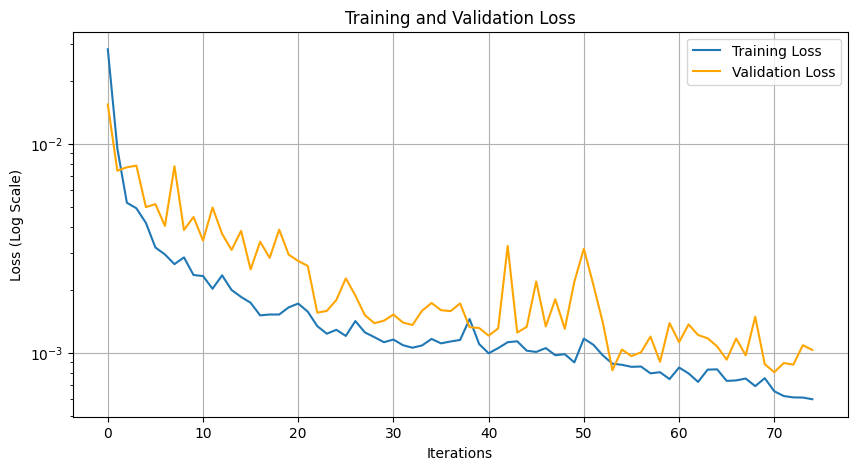

In [39]:
if conf.train_mode == "k-fold":
  ## Trainning
  train_start_time = time.time() # ËÆ∞ÂΩïÊó∂Èó¥
  model_train_KFold(num_epochs=100,
                    learning_rate=0.0002,
                    num_fold=8)

  ## Save and Record
  torch.save(model.state_dict(), "3d_cnn_model_v2.pth") # ÂÜçÊ¨°‰øùÂ≠òÊ®°Âûã
  train_end_time = time.time() # ËÆ∞ÂΩïÊó∂Èó¥
  trainning_time = train_end_time - train_start_time # ËÆ°ÁÆóËÆ≠ÁªÉÊó∂Èó¥

  ## Print
  print("‚úÖ ÁªßÁª≠ËÆ≠ÁªÉÂÆåÊàêÔºåÂ∑≤‰øùÂ≠ò‰∏∫ `3d_cnn_model_v2.pth`")
  print(f"üïõ ËÆ≠ÁªÉËÄóÊó∂: {trainning_time:.2f} Áßí")

  ## Plot: loss
  plot_loss(plot_val_loss=True)

## 4.2. OPTION: Simple 2-stage trainning

In [40]:
if conf.train_mode == "simple":
  ## Trainning: stage-1
  train_start_time = time.time() # ËÆ∞ÂΩïÊó∂Èó¥
  model_train_simple(num_epochs=2,learning_rate=0.0002) # ËÆ≠ÁªÉ
  torch.save(model.state_dict(), "3d_cnn_model.pth") # save
  print("‚úÖ Ê®°ÂûãËÆ≠ÁªÉÂÆåÊàêÔºåÂ∑≤‰øùÂ≠òÔºÅ")


  ## Trainning: stage-2
  model.load_state_dict(torch.load("3d_cnn_model.pth")) # load model
  model_train_simple(num_epochs=2,learning_rate=0.0001) # train

  ## Save and Record
  torch.save(model.state_dict(), "3d_cnn_model_v2.pth") # ÂÜçÊ¨°‰øùÂ≠òÊ®°Âûã
  train_end_time = time.time() # ËÆ∞ÂΩïÊó∂Èó¥
  trainning_time = train_end_time - train_start_time # ËÆ°ÁÆóËÆ≠ÁªÉÊó∂Èó¥

  ## Print
  print("‚úÖ ÁªßÁª≠ËÆ≠ÁªÉÂÆåÊàêÔºåÂ∑≤‰øùÂ≠ò‰∏∫ `3d_cnn_model_v2.pth`")
  print(f"üïõ ËÆ≠ÁªÉËÄóÊó∂: {trainning_time:.3f} Áßí")

  ## Plot: loss
  plot_loss()

Note:\
As TC added, 4$e^{-4}$ shows gradient disapper (loss:Nan)\
$\therefore$ 4$e^{-4}$ $\rightarrow$ 2$e^{-4}$\

When reducing the amount of predicting parameters, loss drops faster at the first step (0.007 -> 0.004)

**Note**

when loss = 0.000139, seems to have good prediction capability

# 5.Model Testing

In [41]:
# Âä†ËΩΩÊ®°Âûã
model = conf.model                        # Create an instance of your model
model.load_state_dict(torch.load('3d_cnn_model_v2.pth'))  # Load the saved state_dict
model.eval()                                              # Set the model to evaluation mode

# Áî®‰∫éÂ≠òÂÇ®È¢ÑÊµãÂÄºÂíåÁúüÂÆûÂÄº
predictions_scaled   = []
actual_values_scaled = []


# Áî®‰∫éÂ≠òÂÇ®ÊÄªÁöÑÊçüÂ§±
total_loss    = 0.0
criterion     = conf.criterion
test_loss_history    = []

# Êé®ÁêÜ
reasoning_start_time = time.time() # ËÆ∞ÂΩïÊó∂Èó¥
with torch.no_grad():
    for label, grid, items in tqdm(test_loader, desc=f"Evaluating..."): # Changed description
        label, grid, items = label.to(device), grid.to(device), items.to(device)
        grid    = grid.unsqueeze(1)               # Ê∑ªÂä† channel Áª¥Â∫¶ (channels, depth, height, width) for 3D CNN
        output  = model(grid, items[:, 0])        # TODO: Á°Æ‰øù ËæìÂÖ•grid + temp_i, ÂâçÂêë‰º†Êí≠
        loss    = criterion(output, items[:, 1:]) # TODO: Á°Æ‰øù ËæìÂÖ• temp_i ‰ª•ÂêéÁöÑ
        total_loss += loss.item()

        # Append predictions and actual values to the lists
        predictions_scaled.extend(output.cpu())         # Move predictions to CPU
        actual_values_scaled.extend(items[:, 1:].cpu()) # Move actual values to CPU

        # record
        test_loss_history.append(total_loss / len(test_loader))

reasoning_end_time = time.time() # ËÆ∞ÂΩïÊó∂Èó¥
reasoning_time = reasoning_end_time - reasoning_start_time # ËÆ°ÁÆóÊé®ÁêÜÊó∂Èó¥
print(f"üïõ Êé®ÁêÜËÄóÊó∂: {reasoning_time:.3f} Áßí")
print(f"Test Loss: {total_loss / len(test_loader):.6f}")

Evaluating...: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6/6 [00:03<00:00,  1.69it/s]

üïõ Êé®ÁêÜËÄóÊó∂: 3.562 Áßí
Test Loss: 0.001204


# 6.Model Evaluation

**üìå 8.1 ÁªùÂØπËØØÂ∑Æ (MAE - Mean Absolute Error)**
$$
\text{MAE} = \frac{1}{n} \sum |y_{true} - y_{pred}|
$$

- Ë°°ÈáèÊ®°ÂûãÈ¢ÑÊµãËØØÂ∑ÆÁöÑÂπ≥ÂùáÁªùÂØπÂÄº„ÄÇ
- ‰∏é MSE Áõ∏ÊØîÔºåMAE ‰∏ç‰ºöÊîæÂ§ßËæÉÂ§ßÁöÑËØØÂ∑ÆÔºåÂØπÂºÇÂ∏∏ÂÄºÔºàoutliersÔºâÊõ¥È≤ÅÊ£í„ÄÇ

In [42]:
MAE = mean_absolute_error(actual_values_scaled, predictions_scaled)
print(f"üìâ MAE: {MAE:.4f}")

üìâ MAE: 0.0241


**üìå 8.2 ÂùáÊñπËØØÂ∑Æ(MSE - Mean Squared Error)**
$$
\text{MSE} = \frac{1}{n} \sum \left(y_{true} - y_{pred}\right)^2
$$

- Ë°°ÈáèÊ®°ÂûãÈ¢ÑÊµãËØØÂ∑ÆÁöÑÂπ≥ÊñπÂπ≥ÂùáÂÄºÔºåÊîæÂ§ßËæÉÂ§ßËØØÂ∑ÆÔºåÂØπÂºÇÂ∏∏ÂÄºÊïèÊÑü„ÄÇ


In [43]:
MSE = mean_squared_error(actual_values_scaled, predictions_scaled)
print(f"üìâ MSE: {MSE:.4f}")

üìâ MSE: 0.0012


**üìå 8.3. ÂùáÊñπÊ†πËØØÂ∑Æ(RMSE - Root Mean Squared Error)**
$$
RMSE = \sqrt{MSE}
$$

- RMSE = MSE ÂºÄÂπ≥ÊñπÔºåÂçï‰Ωç‰∏éÂéüÂèòÈáè‰∏ÄËá¥ÔºåÊõ¥ÊòìËß£Èáä„ÄÇ

In [44]:
RMSE = np.sqrt(MSE)
print(f"üìâ RMSE: {RMSE:.4f}")

üìâ RMSE: 0.0350


**üìå 8.4 Âπ≥ÂùáÁôæÂàÜÊØîËØØÂ∑Æ(MAPE - Mean Absolute Percentage Error)**
$$
MAPE = \frac{1}{n} \sum \left| \frac{y_{true} - y_{pred}}{y_{true}} \right| x 100 \text{%}
$$

- Ë°°ÈáèÈ¢ÑÊµãËØØÂ∑ÆÁõ∏ÂØπ‰∫éÁúüÂÆûÂÄºÁöÑÁôæÂàÜÊØîÔºåÈÄÇÁî®‰∫é‰∏çÂêåÂ∞∫Â∫¶ÁöÑÊï∞ÊçÆ„ÄÇ
- ‚ö†Ô∏è ÈÄÇÁî®‰∫éÈùûË¥üÊï∞ÊçÆÔºåÂê¶ÂàôÂèØËÉΩ‰ºöÊä•Èîô„ÄÇ


In [45]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE = mean_absolute_percentage_error(np.array(actual_values_scaled), np.array(predictions_scaled))
print(f"üìâ MAPE: {MAPE:.2f}%")

üìâ MAPE: inf%


<ipython-input-45-52ec4e328dbf>:2: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


**üìå 8.5 Ëß£ÈáäÊñπÂ∑ÆÂæóÂàÜ(Explained Variance Score)**
$$
EVS = 1 - \frac{Var(y_{true}-y_{pred})}{Var(y_{true})}
$$

- Ë°°ÈáèÊ®°ÂûãÂØπÊï∞ÊçÆÊñπÂ∑ÆÁöÑËß£ÈáäËÉΩÂäõÔºåÁ±ª‰ºº R¬≤Ôºå‰ΩÜ‰∏çÂèóÊï∞ÊçÆÁº©ÊîæÂΩ±Âìç„ÄÇ

In [46]:
EVS = explained_variance_score(actual_values_scaled, predictions_scaled)
print(f"üìä Explained Variance Score: {EVS:.4f}")

üìä Explained Variance Score: 0.9466


**üìå 8.6 Âπ≥ÂùáÂØπÊï∞ËØØÂ∑Æ(MSLE - Mean Squared Logarithmic Error)**
$$
\text{MSLE} = \frac{1}{n} \sum \left( \log(1 + y_{\text{true}}) - \log(1 + y_{\text{pred}}) \right)^2
$$

- ÈÄÇÁî®‰∫éÈ¢ÑÊµãÂÄºÂèòÂåñËåÉÂõ¥ËæÉÂ§ßÁöÑÊÉÖÂÜµÔºàÂ¶ÇÈ¢ÑÊµãÊî∂ÂÖ•„ÄÅ‰∫∫Âè£Á≠âÔºâ„ÄÇ
- ÈÅøÂÖçÊûÅÁ´ØÂÄºÂΩ±ÂìçÔºåÊõ¥ÂÖ≥Ê≥®Áõ∏ÂØπËØØÂ∑Æ„ÄÇ
- ‚ö†Ô∏è ÈÄÇÁî®‰∫éÈùûË¥üÊï∞ÊçÆÔºåÂê¶ÂàôÂèØËÉΩ‰ºöÊä•Èîô„ÄÇ


In [47]:
MSLE = mean_squared_log_error(actual_values_scaled, predictions_scaled)
print(f"üìâ MSLE: {MSLE:.4f}")

üìâ MSLE: 0.0007


**üìå 8.7 ÁöÆÂ∞îÈÄäÁõ∏ÂÖ≥Á≥ªÊï∞ÔºàPearson Correlation CoefficientÔºâ**
$$
\text{PCC} = \frac{\text{Cov}(y_{\text{true}}, y_{\text{pred}})}{\sigma_{y_{\text{true}}} \cdot \sigma_{y_{\text{pred}}}}
$$

- Ë°°ÈáèÈ¢ÑÊµãÂÄºÂíåÁúüÂÆûÂÄº‰πãÈó¥ÁöÑÁ∫øÊÄßÁõ∏ÂÖ≥ÊÄßÔºåËåÉÂõ¥Âú® \([-1,1]\) ‰πãÈó¥Ôºö
  - **+1** Ë°®Á§∫ÂÆåÂÖ®Ê≠£Áõ∏ÂÖ≥
  - **0** Ë°®Á§∫Êó†Áõ∏ÂÖ≥ÊÄß
  - **-1** Ë°®Á§∫ÂÆåÂÖ®Ë¥üÁõ∏ÂÖ≥


In [48]:
PCC, _ = scipy.stats.pearsonr(np.array(actual_values_scaled).flatten(), np.array(predictions_scaled).flatten())
print(f"üìà Pearson Correlation Coefficient: {PCC:.4f}")

üìà Pearson Correlation Coefficient: 0.9928


**üìå 8.7 ÊñπËØØÂ∑Æ($R^{2}$ )**
**R¬≤ ÂÖ¨Âºè**

$$ R^2 = 1 - \frac{SS_{res}}{SS_{tot}} $$

ÂÖ∂‰∏≠Ôºö

- $SS$ = Sum of Squares
- $SS_{res} = \sum (y_{\text{true}} - y_{\text{pred}})^2$ ‚Äî‚Äî ÊÆãÂ∑ÆÂπ≥ÊñπÂíå
- $SS_{tot} = \sum (y_{\text{true}} - \bar{y}_{\text{true}})^2$ ‚Äî‚Äî ÊÄªÂπ≥ÊñπÂíå
- $\bar{y}_{\text{true}}$ ÊòØÁúüÂÆûÂÄºÁöÑÂùáÂÄº„ÄÇ

**R¬≤ ÁöÑËß£Èáä**

- **\( R^2 = 1.0 \)**ÔºöÊ®°ÂûãÂÆåÁæéÊãüÂêàÊï∞ÊçÆ„ÄÇ
- **\( 0 < R^2 < 1 \)**ÔºöÊ®°ÂûãÊúâ‰∏ÄÂÆöÁöÑËß£ÈáäËÉΩÂäõÔºå‰ΩÜ‰ªçÊúâËØØÂ∑Æ„ÄÇ
- **\( R^2 $\leq$ 0 \)**ÔºöÊ®°ÂûãÁîöËá≥ÊØîÁÆÄÂçïÁöÑÂùáÂÄºÈ¢ÑÊµãËøòÂ∑Æ„ÄÇ



In [49]:
# ËÆ°ÁÆó R¬≤ Score
R2 = r2_score(actual_values_scaled, predictions_scaled)
print(f"üìä R¬≤ Score: {R2:.4f}")

üìä R¬≤ Score: 0.9408


**üìå 8.8 ËÆ≠ÁªÉ‰∏éÊé®ÁêÜËÄóÊó∂ (Time consumed)**

In [50]:
# ËæìÂá∫ËØÑ‰º∞ÁªìÊûú
print(f"üïõ ËÆ≠ÁªÉËÄóÊó∂Ôºö{trainning_time:3f} Áßí")
print(f"üïõ Êé®ÁêÜËÄóÊó∂: {reasoning_time:.3f} Áßí")

üïõ ËÆ≠ÁªÉËÄóÊó∂Ôºö5078.200954 Áßí
üïõ Êé®ÁêÜËÄóÊó∂: 3.562 Áßí


üìå 8.9 ÂØπÊØîÊÄªÁªì

| ÊåáÊ†á  | ‰ΩúÁî® | ÈÄÇÁî®Âú∫ÊôØ |
|------|------|--------|
| **MSE**  | ËØØÂ∑ÆÂπ≥ÊñπÂπ≥ÂùáÔºåÊîæÂ§ßÂºÇÂ∏∏ÂÄº | ÂÖ≥Ê≥®Â§ßËØØÂ∑Æ |
| **RMSE** | MSE ÂºÄÂπ≥ÊñπÔºå‰∏éÁúüÂÆûÂÄºÂçï‰Ωç‰∏ÄËá¥ | Áõ¥ËßÇËß£ÈáäËØØÂ∑Æ |
| **MAE**  | ËØØÂ∑ÆÁªùÂØπÂÄºÂπ≥Âùá | ÊäóÂºÇÂ∏∏ÂÄºËÉΩÂäõÂº∫ |
| **MAPE** | ËØØÂ∑ÆÁöÑÁõ∏ÂØπÁôæÂàÜÊØî | ÈÄÇÁî®‰∫é‰∏çÂêåÂ∞∫Â∫¶Êï∞ÊçÆ |
| **R¬≤**   | Ëß£ÈáäÊ®°ÂûãÁöÑÊãüÂêàÁ®ãÂ∫¶ | Ë°°ÈáèÊï¥‰ΩìÊïàÊûú |
| **EVS**  | Ëß£ÈáäÊï∞ÊçÆÊñπÂ∑ÆÁöÑËÉΩÂäõ | Á±ª‰ºº R¬≤Ôºå‰ΩÜ‰∏çÂèóÁº©ÊîæÂΩ±Âìç |
| **MSLE** | ËÆ°ÁÆóÂØπÊï∞ËØØÂ∑Æ | ÈÄÇÁî®‰∫éÊåáÊï∞Â¢ûÈïøÈóÆÈ¢ò |
| **PCC**  | Áõ∏ÂÖ≥ÊÄßÂàÜÊûê | Âà§Êñ≠È¢ÑÊµãÂÄº‰∏éÁúüÂÆûÂÄºÁöÑÁ∫øÊÄßÁõ∏ÂÖ≥ÊÄß |

---

üìå 8.10 ÁªìËÆ∫

‚úÖ **Â¶ÇÊûú‰Ω†ÂÖ≥Ê≥®ËØØÂ∑ÆÁöÑÂÆûÈôÖÂ§ßÂ∞è**Ôºö‰ΩøÁî® **MSE / RMSE / MAE**  
‚úÖ **Â¶ÇÊûú‰Ω†ÈúÄË¶ÅÊ†áÂáÜÂåñÁöÑÊ®°ÂûãËØÑ‰ª∑**Ôºö‰ΩøÁî® **R¬≤ / EVS**  
‚úÖ **Â¶ÇÊûúÊï∞ÊçÆÂÖ∑Êúâ‰∏çÂêåÂ∞∫Â∫¶**Ôºö‰ΩøÁî® **MAPE**  
‚úÖ **Â¶ÇÊûúÊï∞ÊçÆÂàÜÂ∏ÉÊúâÈïøÂ∞æÊïàÂ∫îÔºàÊåáÊï∞Â¢ûÈïøÔºâ**Ôºö‰ΩøÁî® **MSLE**  
‚úÖ **Â¶ÇÊûú‰Ω†ÊÉ≥ÂàÜÊûêÈ¢ÑÊµãÂÄºÂíåÁúüÂÆûÂÄºÁöÑÁõ∏ÂÖ≥ÊÄß**Ôºö‰ΩøÁî® **PCC**  



# 7.Vissualization

In [51]:
# check ÂΩí‰∏ÄÂåñÂèÇÊï∞
def scaler_checker(idx,scaler=joblib.load("scaler.pkl")):
  print(f'item:\t{conf.DB_items[idx]}\n'
      f'min:\t{scaler.data_min_[idx]:.2f} \t\t# ËÆ≠ÁªÉÊï∞ÊçÆÁöÑÊúÄÂ∞èÂÄº (ÊØèÂàó) \n'
      f'max:\t{scaler.data_max_[idx]:.2f} \t\t# ËÆ≠ÁªÉÊï∞ÊçÆÁöÑÊúÄÂ§ßÂÄº (ÊØèÂàó) \n'
      f'range:\t{scaler.data_range_[idx]:.2f} \t\t# max - min (ÊØèÂàó) \n'
      f'offset:\t{scaler.min_[idx]:.2f} \t\t# ÂΩí‰∏ÄÂåñÂÅèÁßªÈáèÔºåËÆ°ÁÆóÂÖ¨ÂºèÔºö`-min * scaler`\n'
      f'scaler:\t{scaler.scale_[idx]:.2f} \t\t# ÂΩí‰∏ÄÂåñÊØî‰æãÂõ†Â≠êÔºåËÆ°ÁÆóÂÖ¨ÂºèÔºö`1 / data_range_`\n')

In [52]:
for idx in range(1,len(conf.DB_items)):
  scaler_checker(idx)

item:	len
(A)
min:	2.00 		# ËÆ≠ÁªÉÊï∞ÊçÆÁöÑÊúÄÂ∞èÂÄº (ÊØèÂàó) 
max:	20.00 		# ËÆ≠ÁªÉÊï∞ÊçÆÁöÑÊúÄÂ§ßÂÄº (ÊØèÂàó) 
range:	18.00 		# max - min (ÊØèÂàó) 
offset:	-0.11 		# ÂΩí‰∏ÄÂåñÂÅèÁßªÈáèÔºåËÆ°ÁÆóÂÖ¨ÂºèÔºö`-min * scaler`
scaler:	0.06 		# ÂΩí‰∏ÄÂåñÊØî‰æãÂõ†Â≠êÔºåËÆ°ÁÆóÂÖ¨ÂºèÔºö`1 / data_range_`

item:	density
(g/cm^3)
min:	0.02 		# ËÆ≠ÁªÉÊï∞ÊçÆÁöÑÊúÄÂ∞èÂÄº (ÊØèÂàó) 
max:	0.88 		# ËÆ≠ÁªÉÊï∞ÊçÆÁöÑÊúÄÂ§ßÂÄº (ÊØèÂàó) 
range:	0.86 		# max - min (ÊØèÂàó) 
offset:	-0.02 		# ÂΩí‰∏ÄÂåñÂÅèÁßªÈáèÔºåËÆ°ÁÆóÂÖ¨ÂºèÔºö`-min * scaler`
scaler:	1.16 		# ÂΩí‰∏ÄÂåñÊØî‰æãÂõ†Â≠êÔºåËÆ°ÁÆóÂÖ¨ÂºèÔºö`1 / data_range_`

item:	pore_radius
(A)
min:	6.41 		# ËÆ≠ÁªÉÊï∞ÊçÆÁöÑÊúÄÂ∞èÂÄº (ÊØèÂàó) 
max:	160.60 		# ËÆ≠ÁªÉÊï∞ÊçÆÁöÑÊúÄÂ§ßÂÄº (ÊØèÂàó) 
range:	154.19 		# max - min (ÊØèÂàó) 
offset:	-0.04 		# ÂΩí‰∏ÄÂåñÂÅèÁßªÈáèÔºåËÆ°ÁÆóÂÖ¨ÂºèÔºö`-min * scaler`
scaler:	0.01 		# ÂΩí‰∏ÄÂåñÊØî‰æãÂõ†Â≠êÔºåËÆ°ÁÆóÂÖ¨ÂºèÔºö`1 / data_range_`

item:	porosity
(unitless)
min:	0.81 		# ËÆ≠ÁªÉÊï∞ÊçÆÁöÑÊúÄÂ∞èÂÄº (ÊØèÂàó) 
max:	1.00 		# ËÆ≠ÁªÉÊï∞

ÂΩí‰∏ÄÂåñÂÖ¨ÂºèÔºö
$$
X_{\text{scaled}} = \frac{X - X_{\min}}{X_{\max} - X_{\min}}
$$

ÂèçÂΩí‰∏ÄÂåñÔºö
$$
X_{\text{original}} = X_{\text{scaled}} \times (X_{\max} - X_{\min}) + X_{\min}
$$

Range:
$$
X_{\text{range}} = X_{\max} - X_{\min}
$$

Offset:
$$
X_{\text{offset}} = - X_{\min} \times X_{\text{scaler}}
$$

Scaler:
$$
X_{\text{scaler}} = \frac{1}{X_{\text{range}}}
$$

In [53]:
# ËΩ¨Êç¢‰∏∫ numpy Êï∞ÁªÑ
predictions_scaled   = np.array(predictions_scaled).copy()
actual_values_scaled = np.array(actual_values_scaled).copy()

# ÂèçÂΩí‰∏ÄÂåñ
reverse_nromalization = True
if reverse_nromalization:
  scaler          = joblib.load("scaler.pkl")
  scaler.min_     = scaler.min_[1:] # Âè™ÈÄâÊã© scaler ÁöÑÂâç 2 Áª¥
  scaler.scale_   = scaler.scale_[1:]
  predictions     = scaler.inverse_transform(predictions_scaled)
  actual_values   = scaler.inverse_transform(actual_values_scaled)
# ‰∏çÂÅöÂèçÂΩí‰∏ÄÂåñ
else:
  predictions     = predictions_scaled
  actual_values   = actual_values_scaled

In [54]:
# ÂÆö‰πâÁªòÂõæÂèÇÊï∞
def plot_prediction_results(actual_values, predictions, target_idx):
    """
    ÁªòÂà∂È¢ÑÊµãÁªìÊûúÂàÜÊûêÂõæÔºàÈ¢ÑÊµã vs ÁúüÂÆûÂÄº„ÄÅËØØÂ∑ÆÂàÜÂ∏É„ÄÅËØØÂ∑Æ vs ÁúüÂÆûÂÄºÔºâ

    ÂèÇÊï∞Ôºö
    - actual_values: ÁúüÂÆûÂÄºÁöÑ NumPy Êï∞ÁªÑ (N, 2)
    - predictions: È¢ÑÊµãÂÄºÁöÑ NumPy Êï∞ÁªÑ (N, 2)
    - target_idx: ÁõÆÊ†áÂèòÈáèÁ¥¢ÂºïÔºà0 Êàñ 1Ôºâ
    - target_name: ÁõÆÊ†áÂèòÈáèÁöÑÂêçÁß∞ (str)
    """
    target_name = conf.DB_items[target_idx + 1].replace('\n', ' ')  # skip temp
    errors = predictions[:, target_idx] - actual_values[:, target_idx]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1Ô∏è‚É£ È¢ÑÊµãÂÄº vs ÁúüÂÆûÂÄº
    axes[0].scatter(actual_values[:, target_idx], predictions[:, target_idx], c='blue', label='Predictions')
    axes[0].plot([min(actual_values[:, target_idx]), max(actual_values[:, target_idx])],
                 [min(actual_values[:, target_idx]), max(actual_values[:, target_idx])], 'r--', label='Ideal fit')
    axes[0].set_xlabel(f'Actual Values ({target_name})')
    axes[0].set_ylabel(f'Predicted Values ({target_name})')
    axes[0].set_title(f'Predicted vs Actual Values ({target_name})')
    axes[0].legend()
    axes[0].grid(True)

    # 2Ô∏è‚É£ ËØØÂ∑ÆÂàÜÂ∏ÉÁõ¥ÊñπÂõæ
    axes[1].hist(errors, bins=25, color='purple', edgecolor='black')
    axes[1].set_xlabel(f'Prediction Error ({target_name})')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'Distribution of Prediction Errors ({target_name})')
    axes[1].grid(True)

    # 3Ô∏è‚É£ ËØØÂ∑Æ vs ÁúüÂÆûÂÄº
    axes[2].scatter(actual_values[:, target_idx], errors, c='green')
    axes[2].axhline(y=0, color='r', linestyle='--')
    axes[2].set_xlabel(f'Actual Values ({target_name})')
    axes[2].set_ylabel(f'Prediction Error ({target_name})')
    axes[2].set_title(f'Prediction Error vs Actual Values ({target_name})')
    axes[2].grid(True)

    plt.tight_layout()
    plt.savefig(f'Prediction_Results.png')
    plt.show()

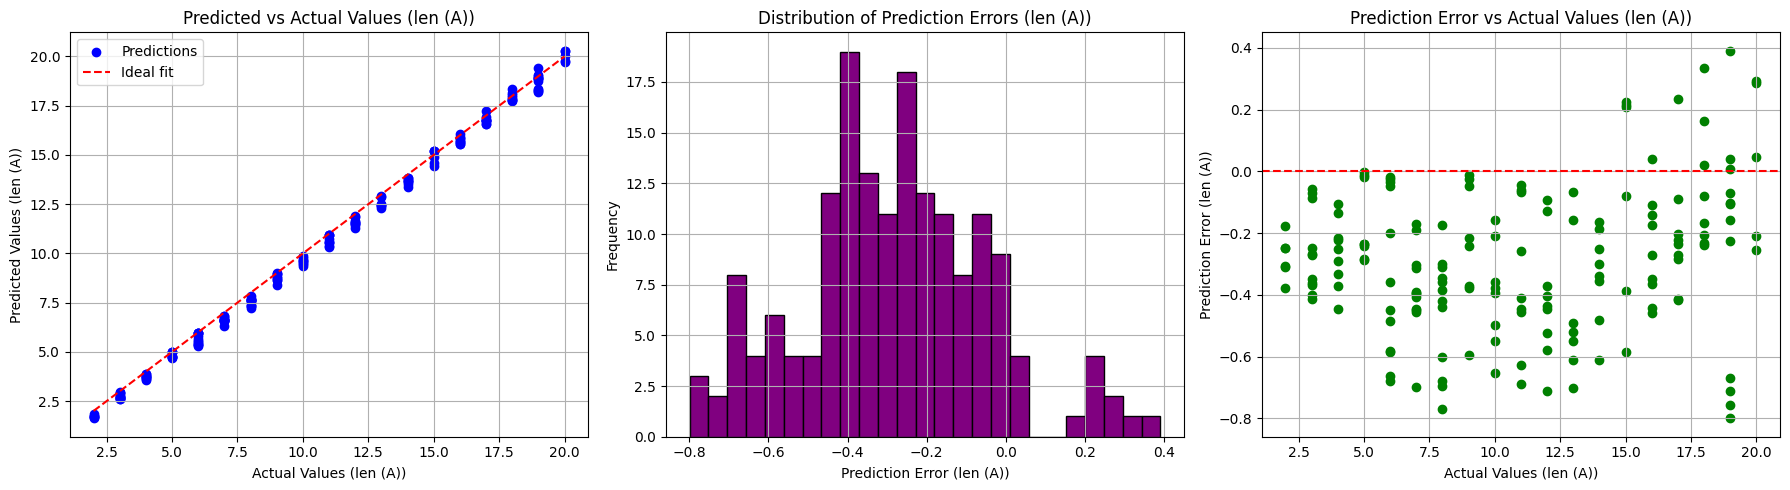

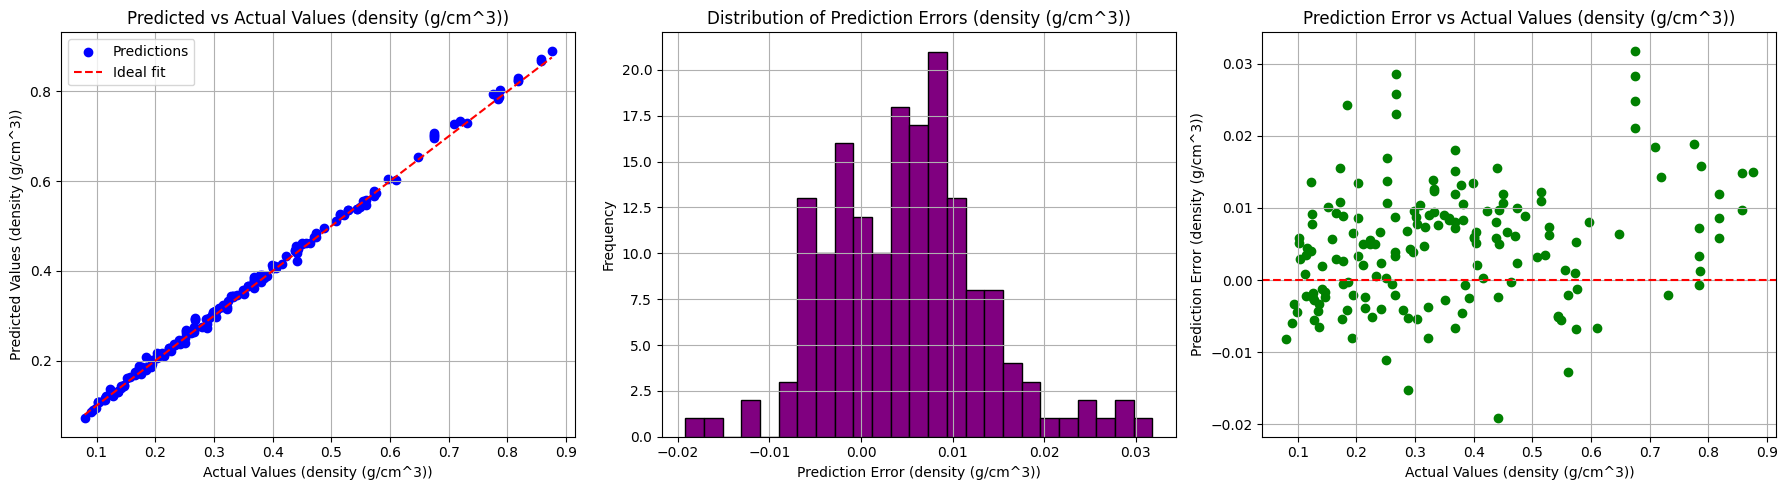

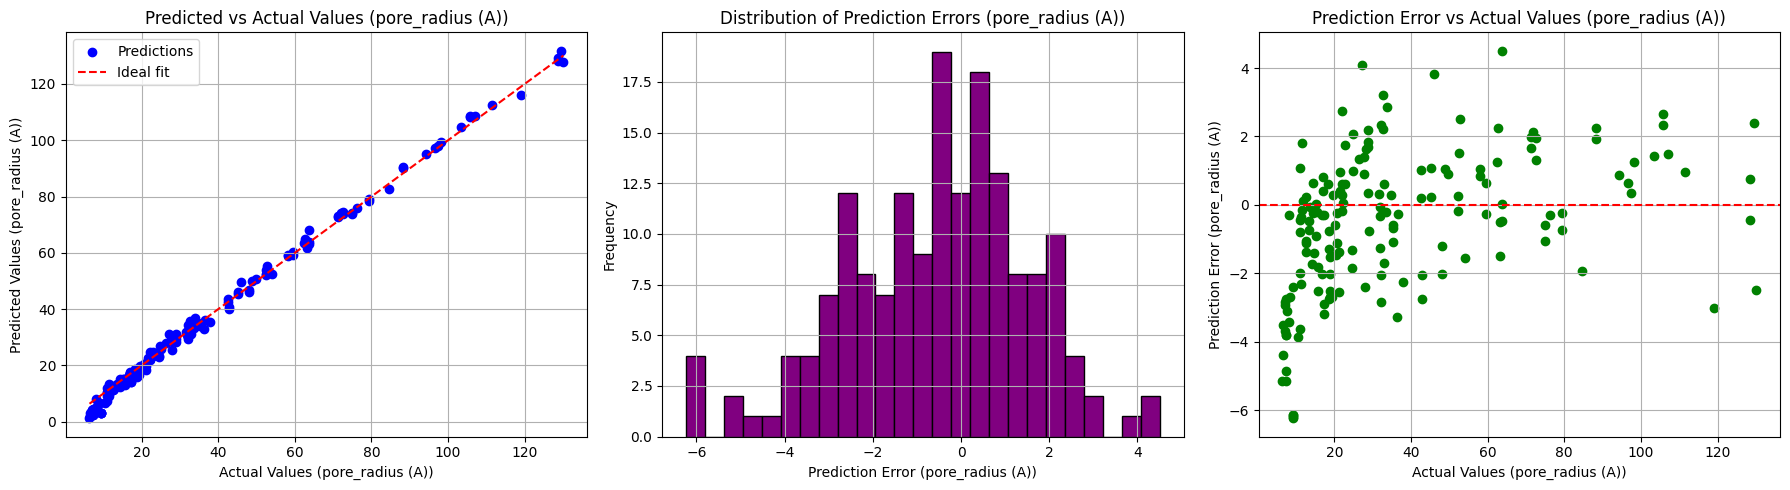

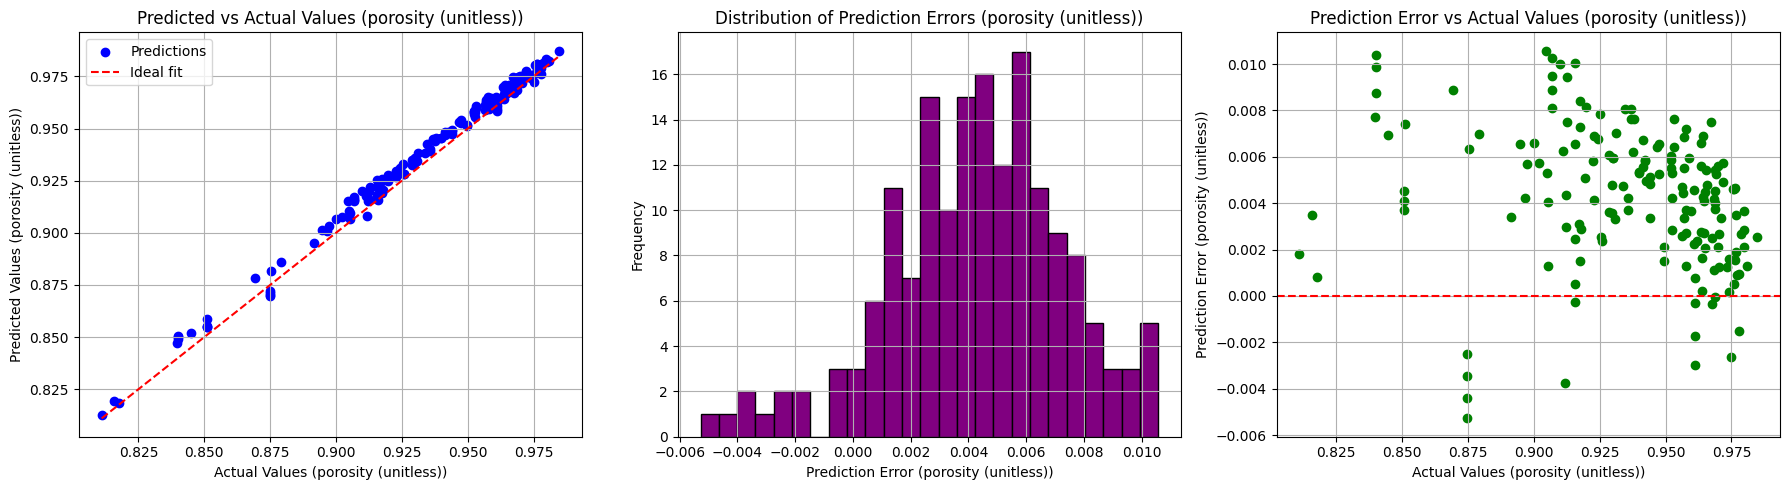

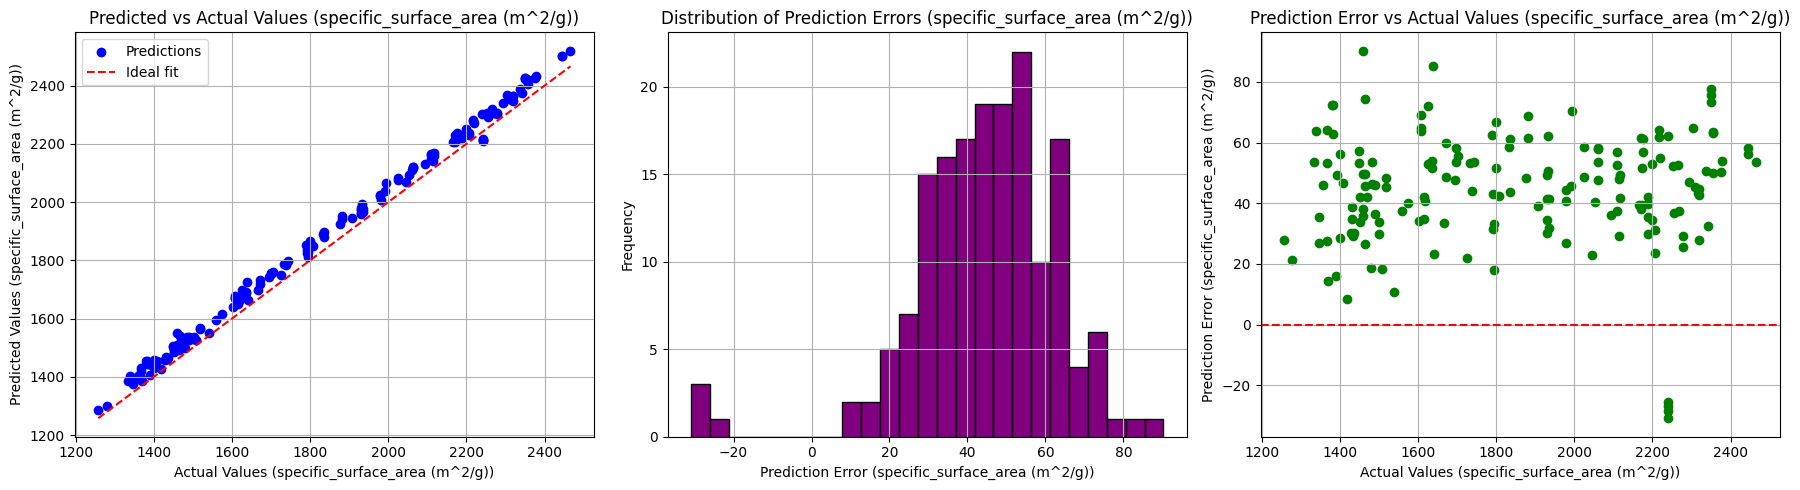

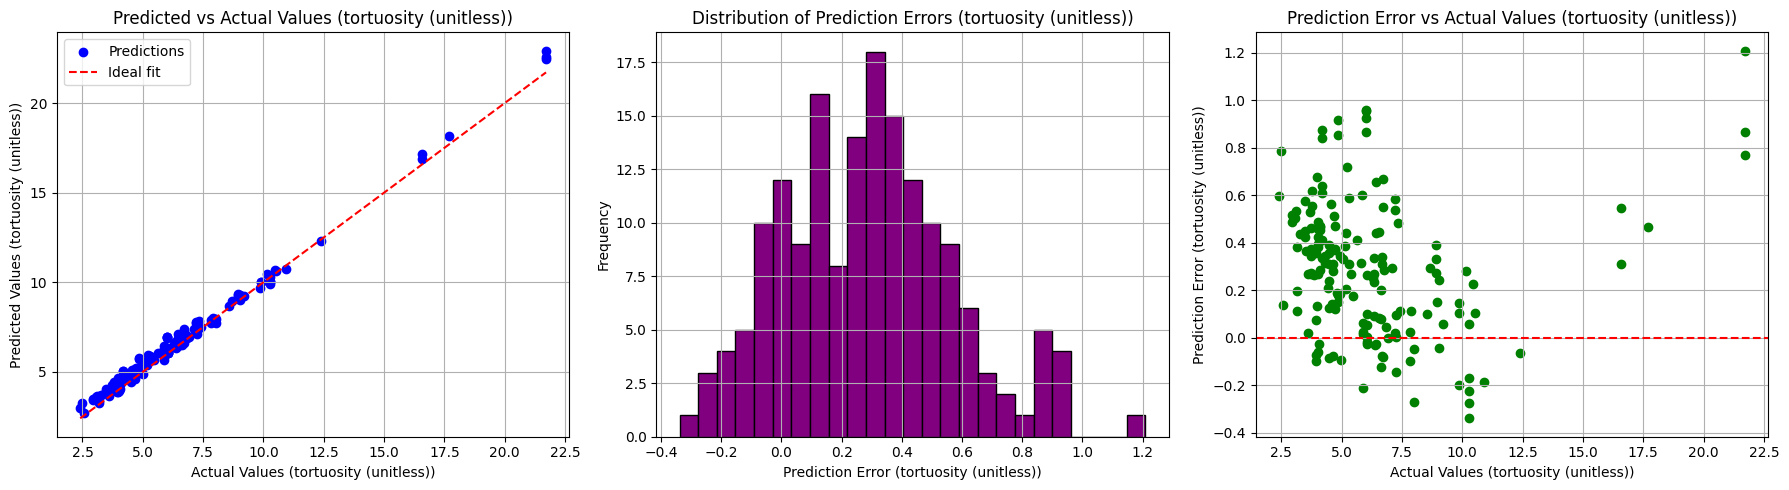

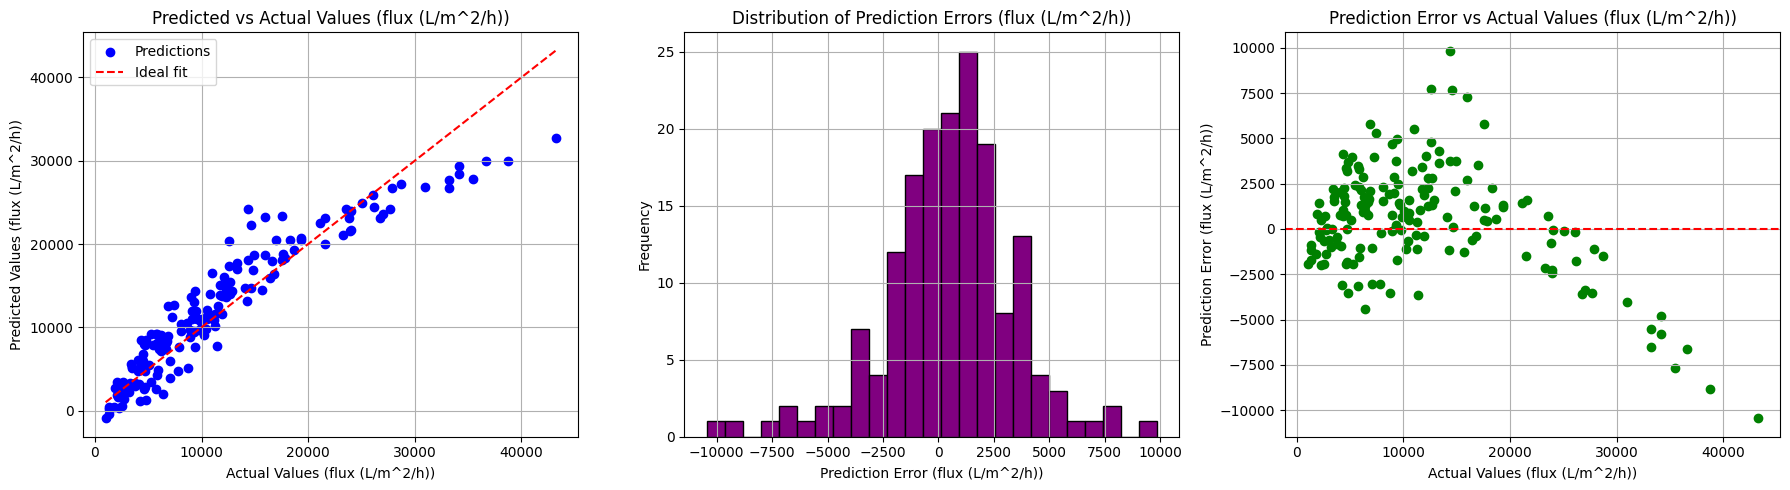

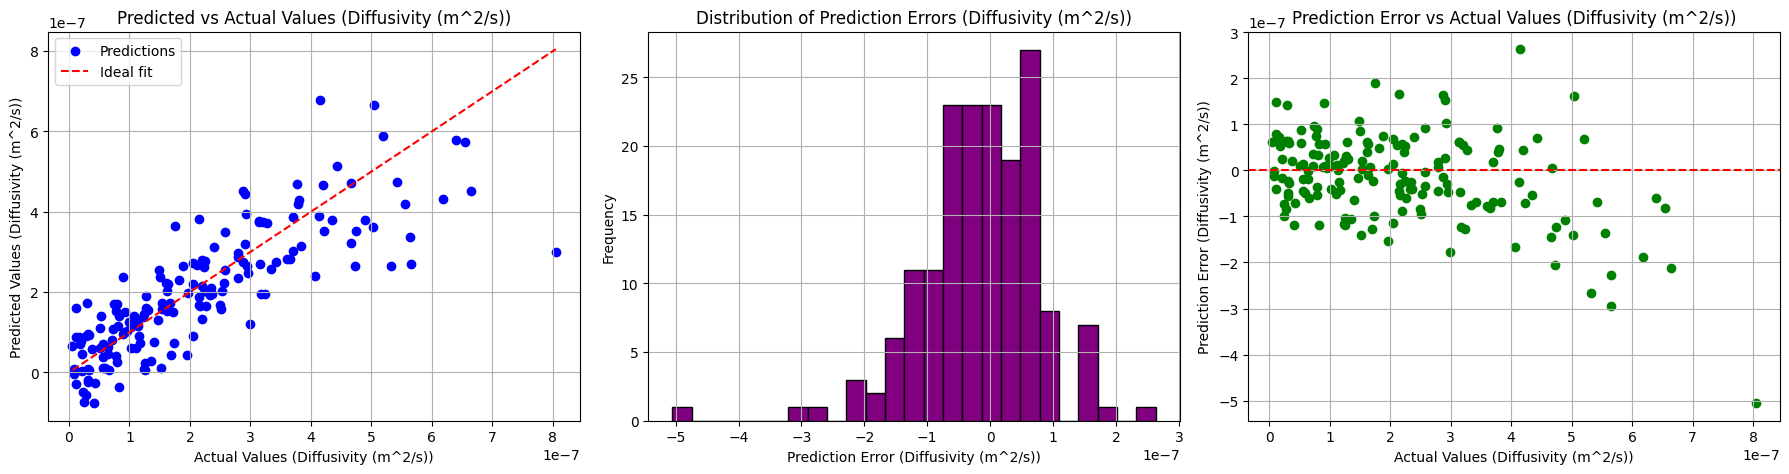

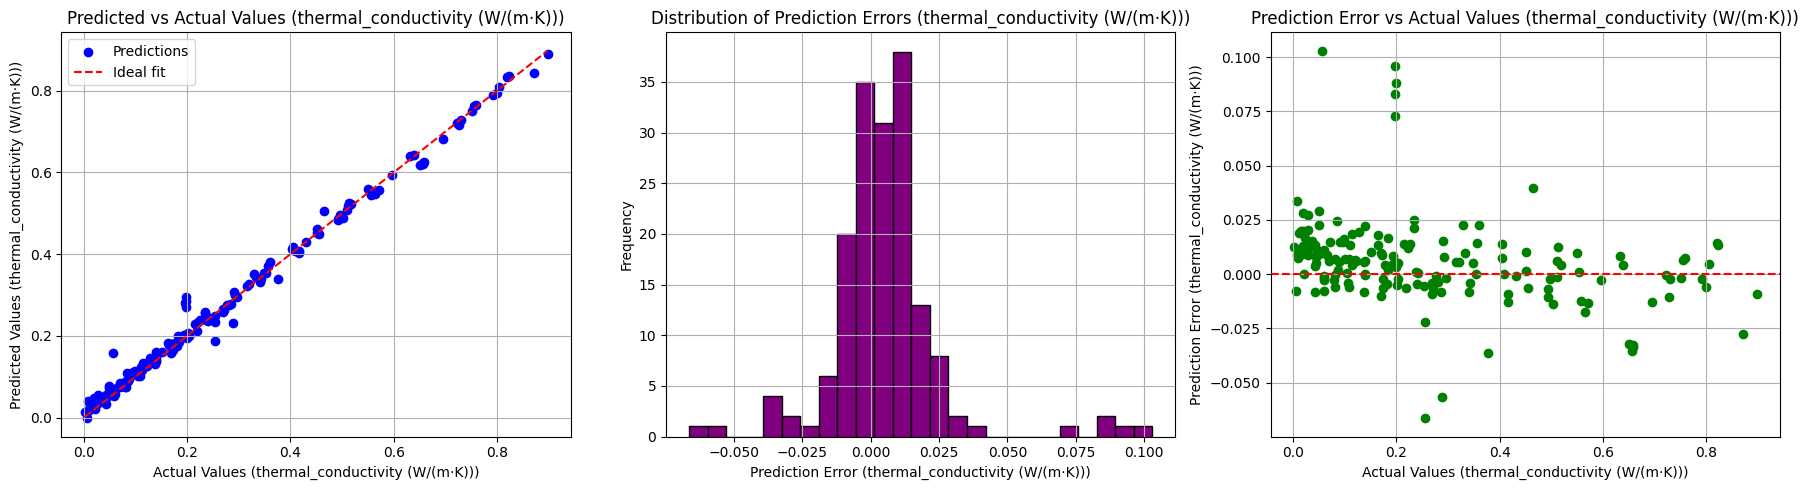

In [55]:
# Ë∞ÉÁî®ÂáΩÊï∞ÁªòÂà∂ÁõÆÊ†áÂÄº 1 (Target 1)
for idx in range(0,predictions.shape[1]):
  plot_prediction_results(actual_values, predictions, target_idx=idx)

# 8.Save

In [56]:
## Save file ##

# Ëé∑ÂèñÂΩìÂâçÊó∂Èó¥Êà≥ÔºàÊ†ºÂºèÔºöYYYYMMDD_HHMMSSÔºâ
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Ëé∑ÂèñÊ®°ÂûãÁ±ªÂûã
model_type = type(model).__name__  # ÊèêÂèñÊ®°ÂûãÁ±ªÂêçÔºåÂ¶Ç "Improved3DCNN"

# ÊûÑÈÄ†Êñá‰ª∂Âêç
file_name = f"model_results_{model_type}_{timestamp}.pkl"
file_path = f"/content/{file_name}"  # Colab ÈªòËÆ§Â≠òÂÇ®Ë∑ØÂæÑ

# ÂàõÂª∫‰øùÂ≠òÂ≠óÂÖ∏
results_dict = {
    "predictions": predictions,
    "actual_values": actual_values,
    "scaler": scaler,
    "train_loss_history": train_loss_history,
    "test_loss_history": test_loss_history,
    "trainning_time": trainning_time,
    "reasoning_time": reasoning_time,
    "R2": R2,
    "MSE": MSE,
    "RMSE": RMSE,
    "MAE": MAE,
    "EVS": EVS,
    "MSLE": MSLE,
    "PCC": PCC
}

# ËÆ∞ÂΩïÂºÄÂßãÊó∂Èó¥
save_start_time = time.time()

# ‰øùÂ≠òÂà∞Êñá‰ª∂
with open(file_path, "wb") as f:
    pickle.dump(results_dict, f)
    pickle.dump(model, f)

# ËÆ∞ÂΩïÁªìÊùüÊó∂Èó¥
save_end_time = time.time()
save_time = save_end_time - save_start_time

# Ëé∑ÂèñÊñá‰ª∂Â§ßÂ∞è
file_size_mb = os.path.getsize(file_path) / (1024 * 1024)

# ÊâìÂç∞Êñá‰ª∂‰ø°ÊÅØ
print(f"‚úÖ ÁªìÊûúÂ∑≤‰øùÂ≠òÂà∞:  {file_path}")
print(f"üíæ Êñá‰ª∂Â§ßÂ∞è:     {file_size_mb:.3f} MB")
print(f"‚è≥ ‰øùÂ≠òËÄóÊó∂       {save_time:.4f} Áßí")
print(f"üìÇ ‰∏ãËΩΩÊñá‰ª∂Âêç:    {file_name}")

‚úÖ ÁªìÊûúÂ∑≤‰øùÂ≠òÂà∞:  /content/model_results_Improved3DCNN_20250502_175419.pkl
üíæ Êñá‰ª∂Â§ßÂ∞è:     8.519 MB
‚è≥ ‰øùÂ≠òËÄóÊó∂       0.0305 Áßí
üìÇ ‰∏ãËΩΩÊñá‰ª∂Âêç:    model_results_Improved3DCNN_20250502_175419.pkl


In [57]:
## Post Check ##
if conf.dev_mode:
  # 1Ô∏è‚É£ ËØªÂèñ‰øùÂ≠òÁöÑÊñá‰ª∂
  if os.path.exists(file_path):
      with open(file_path, "rb") as f:
          loaded_results = pickle.load(f)
      print("‚úÖ ÊàêÂäüÂä†ËΩΩ model_results.pkl")
  else:
      raise FileNotFoundError(f"‚ùå Êú™ÊâæÂà∞Êñá‰ª∂: {file_path}")

  # 2Ô∏è‚É£ ËØªÂèñÂèòÈáè
  expected_keys = [
      "predictions",
      "actual_values",
      "scaler",
      "train_loss_history",
      "test_loss_history",
      "test_loss_history",
      "trainning_time",
      "reasoning_time",
      "R2",
      "MSE",
      "RMSE",
      "MAE",
      "EVS",
      "MSLE",
      "PCC"
  ]

  # Ê£ÄÊü•ÊòØÂê¶ÊâÄÊúâÂèòÈáèÈÉΩÊ≠£Á°ÆÂ≠òÂÇ®
  missing_keys = [key for key in expected_keys if key not in loaded_results]
  if missing_keys:
      print(f"‚ö†Ô∏è Áº∫Â∞ëÂèòÈáè: {missing_keys}")
  else:
      print("‚úÖ ÊâÄÊúâÂèòÈáèÂùáÂ∑≤Ê≠£Á°ÆÂ≠òÂÇ®ÔºÅ")

  # 3Ô∏è‚É£ ÊµãËØïÂèòÈáèÁöÑÈïøÂ∫¶ÂíåÂÜÖÂÆπ
  print("\nüìä ÂèòÈáèÊ£ÄÊü•Êä•Âëä")

  for key, value in loaded_results.items():
      if isinstance(value, (list, tuple, set)):
          print(f"üîπ {key}: ÈïøÂ∫¶ {len(value)}")
      elif isinstance(value, dict):
          print(f"üîπ {key}: ÂåÖÂê´ {len(value.keys())} ‰∏™ÈîÆ")
      elif isinstance(value, (int, float, str)):
          print(f"üîπ {key}: ÂÄº {value}")
      else:
          print(f"üîπ {key}: Á±ªÂûã {type(value)}")

  print("\n‚úÖ Ê†∏È™åÂÆåÊàêÔºÅ")

In [58]:
# ‰∏ãËΩΩÊñá‰ª∂Ôºà‰ªÖÈôê Google ColabÔºâ
from google.colab import files  # ‰ªÖÂú® Google Colab ËøêË°å
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
# ÁªàÊ≠¢‰ºöËØù
#from google.colab import runtime
#runtime.unassign()